In [8]:
import sklearn.gaussian_process as gp

def bayesian_optimization(n_iters, sample_loss, xp, yp):

    # Define the GP
    kernel = gp.kernels.Matern()
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                      alpha=1e-4,
                                      n_restarts_optimizer=10,
                                      normalize_y=True)
    for i in range(n_iters):
        # Update our belief of the loss function
        model.fit(xp, yp)

        # sample_next_hyperparameter is a method that computes the arg
        # max of the acquisition function
        next_sample = sample_next_hyperparameter(model, yp)

        # Evaluate the loss for the new hyperparameters
        next_loss = sample_loss(next_sample)

        # Update xp and yp
        
'''
Arguments:
----------
n_iters: int.
  Number of iterations to run the algorithm for.
sample_loss: function.
  Loss function that takes an array of parameters.
xp: array-like, shape = [n_samples, n_params].
  Array of previously evaluated hyperparameters.
yp: array-like, shape = [n_samples, 1].
  Array of values of `sample_loss` for the hyperparameters
  in `xp`.
'''

'\nArguments:\n----------\nn_iters: int.\n  Number of iterations to run the algorithm for.\nsample_loss: function.\n  Loss function that takes an array of parameters.\nxp: array-like, shape = [n_samples, n_params].\n  Array of previously evaluated hyperparameters.\nyp: array-like, shape = [n_samples, 1].\n  Array of values of `sample_loss` for the hyperparameters\n  in `xp`.\n'

In [2]:
from sklearn.datasets import make_classification

data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def sample_loss(params):
    C = params[0]
    gamma = params[1]

    # Sample C and gamma on the log-uniform scale
    model = SVC(C=10 ** C, gamma=10 ** gamma, random_state=12345)

    # Sample parameters on a log scale
    return cross_val_score(model=model,
                         X=data,
                         y=target,
                         scoring='roc_auc',
                         cv=3).mean()

## from git

In [107]:
""" gp.py
Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params) # бесполезная (разве что ради проверки)
    print('x_to_pred', x_to_predict.shape)

    
    # На той модели предсказываем мю, сигму для x_to_predict
    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)
    print('mu. sigma',mu.shape, sigma.shape)

    
    # Находим оптимальный лосс, из старых значений
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    # if False or 0 == -1, else = 1 - ВЫЕБОНЫ, можно проще
    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero # игнор ошибок
    with np.errstate(divide='ignore'):
        # Считаем З
        Z = scaling_factor * (mu - loss_optimum) / sigma
        print(Z.shape)
        
        # возвращает 100к експ емпрувментов
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0
        print(expected_improvement.shape)

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    # 100 точек, но оптимайзером
    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    # Стартовые точки
    if x0 is None:
                                        # min, max, size
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            # Делаем параметры, считаем функцию для них
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    print(yp)
    
    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            # Генерируем (random_search, len(params)) чисел в нашем промежутке
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            
            # считаем 100к ЕИ, берем наилучшее
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=False, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, 
                                                     greater_is_better=False, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        # Если новая точка ближе на хотя бы епсилон к нашей - выбираем следующую рандомно
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [104]:
with np.errstate(divide='ignore', invalid='ignore'):
    print(np.arange(3) / 0.)

[nan inf inf]


In [108]:
bounds = np.array([[-4, 4], [-4, 4]])

xp, yp = bayesian_optimisation(n_iters=1, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

[18.54043341 33.00011943 32.91604072]
1
x_to_pred (100000, 2)
mu. sigma (100000,) (100000,)
(100000,)
(100000,)


In [70]:
greater_is_better = 0
scaling_factor = (-1) ** (not greater_is_better)
scaling_factor

-1

In [53]:
n_params = 2
random_search = 100000
x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))

In [55]:
x_random.shape

(100000, 2)

In [50]:
n_pre_samples = 2
bounds = np.array([[-4, 4], [-4, 4]])

np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0]))

array([[1.47648218, 3.92034089],
       [0.29984444, 1.06809947]])

In [26]:
from scipy.stats.mstats import gmean

gmean([0.94, 0.93, 0.75])

0.8687417403420845

In [16]:
""" plotters.py
"""

import numpy as np
import matplotlib.pyplot as plt

def plot_iteration(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):
    """ plot_iteration
    Plots a line plot (1D) or heatmap (2D) of the estimated loss function and expected
    improvement acquisition function for each iteration of the Bayesian search algorithm.
    Arguments:
    ----------
        first_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the first parameter.
        sampled_params: array-like, shape = [n_points, n_params]
            Points for which the value of the loss function is computed.
        sampled_loss: function.
            Values of the loss function for the parameters in `sampled_params`.
        first_iter: int.
            Only plot iterations after the `first_iter`-th iteration.
        alpha: float
            Variance of the error term in the GP model.
        greater_is_better: boolean
            Boolean indicating whether we want to maximise or minimise the loss function.
        true_y: array-like, shape = [n, 1] or None
            Array containing the true value of the loss function. If None, the real loss
            is not plotted. (1-dimensional case)
        second_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the second parameter, in case
            of a heatmap.
        param_dims_to_plot: list of length 2
            List containing the indices of `sampled_params` that contain the first and
            second parameter.
        optimum: array-like [1, n_params].
            Maximum value of the loss function.
    """

    # Create the GP
    kernel = gp.kernels.Matern()
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu, std = model.predict(first_param_grid[:, np.newaxis], return_std=True)
            ei = -1 * expected_improvement(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)
            #print('1d')
            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)
            #print('2d')
            fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, sampled_params[:(i+1), param_dims_to_plot], sampled_loss, mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        #if file_path is not None:
        #    plt.savefig('%s/bo_iteration_%d.png' % (filepath, i), bbox_inches='tight')


def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2


def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("C")
    ax1.set_ylabel("gamma")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("C")
    ax2.set_ylabel("gamma")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='gold', s=150)

    return fig, ax1, ax2

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification

data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

# Кросс-валидационный скор для СВМ функции и параметров переданных в нее
def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [9]:
lambdas = np.linspace(1, -4, 25) # От 1 до -4, 25 значений
gammas = np.linspace(1, -4, 20) # От 1 до -4, 20 значений

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas]) # Сетка переборов, 500 значений

real_loss = [sample_loss(params) for params in param_grid] # считаем лосс для каждого

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

array([ 0.58333333, -2.42105263])

In [ ]:
param_grid.shape

In [ ]:
%matplotlib inline

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma')
plt.show()

In [46]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.17600741e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d
2d


/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2d
2d
2d
2d
2d
2d
2d
2d


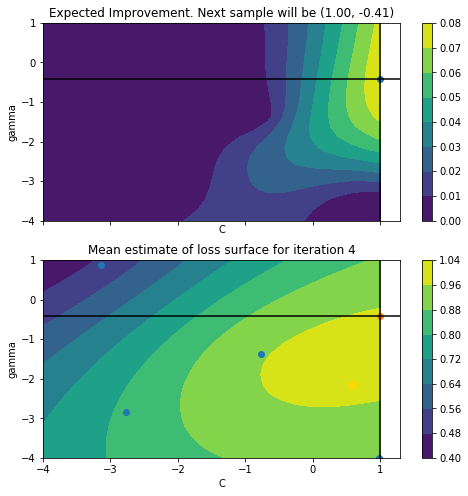

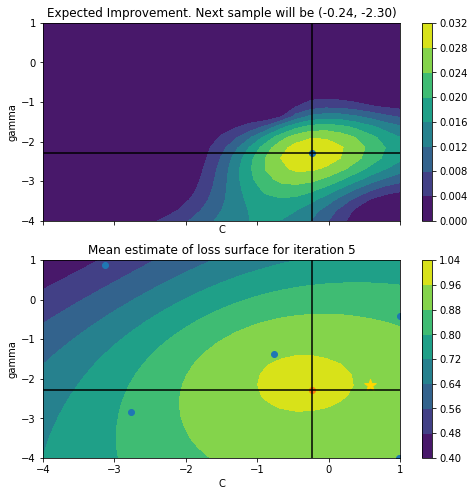

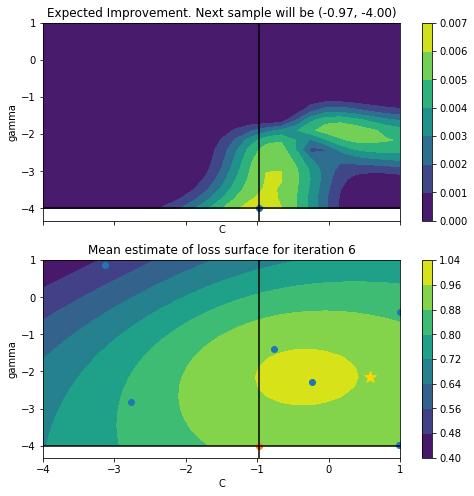

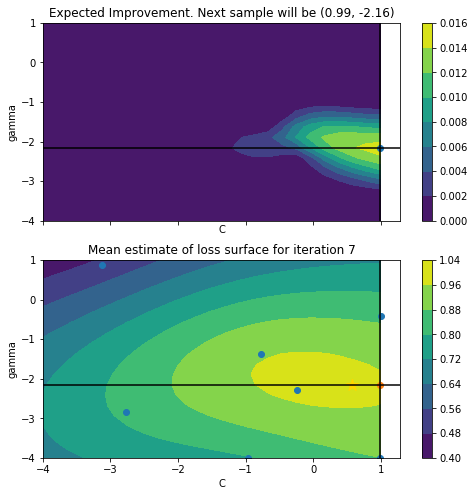

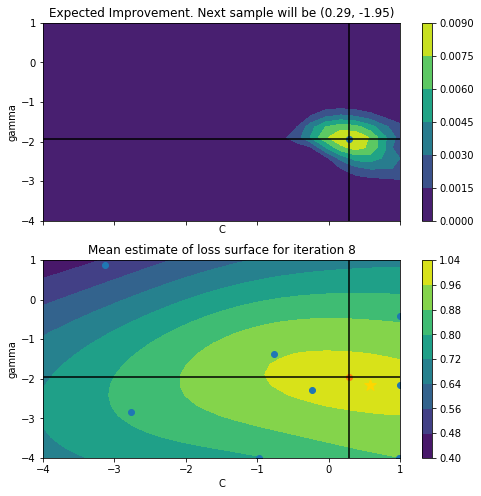

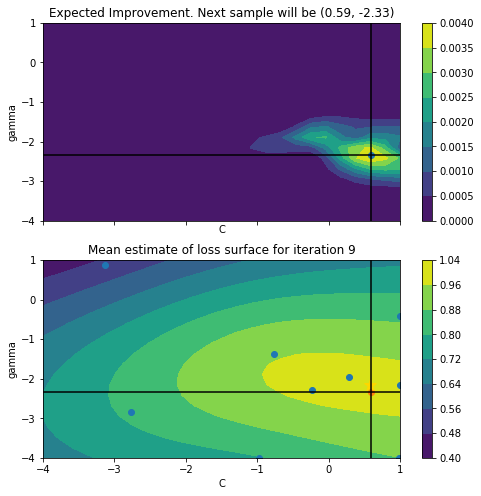

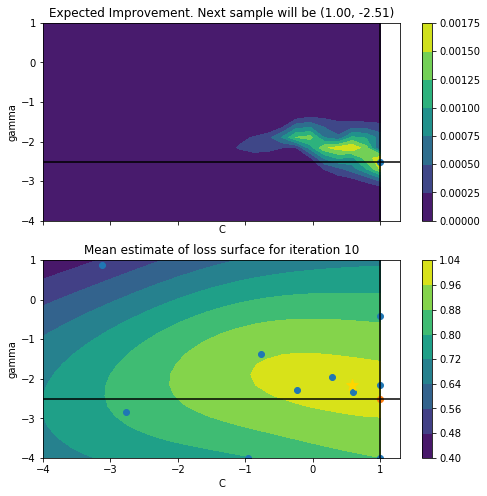

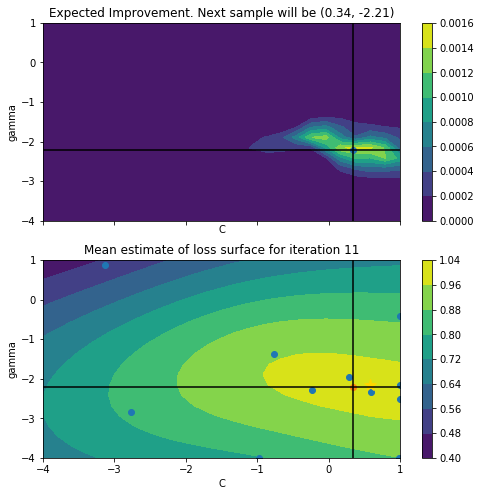

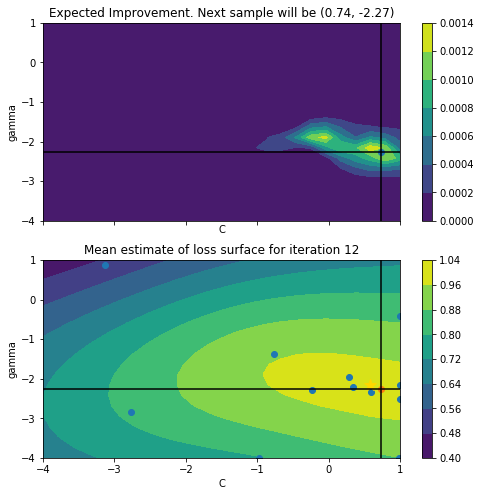

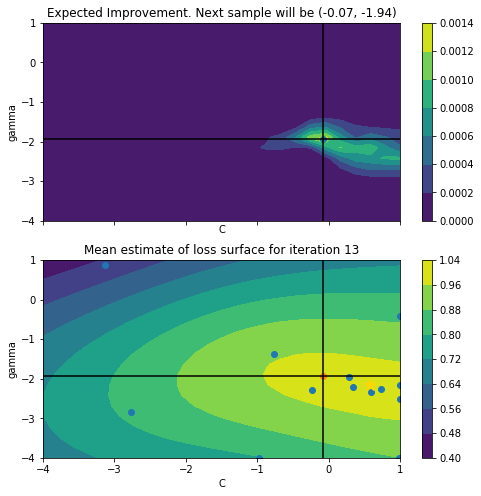

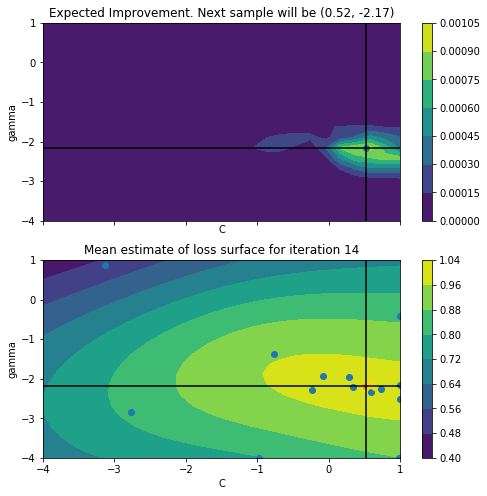

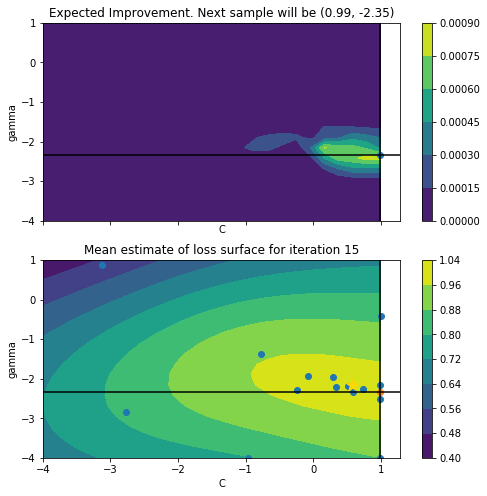

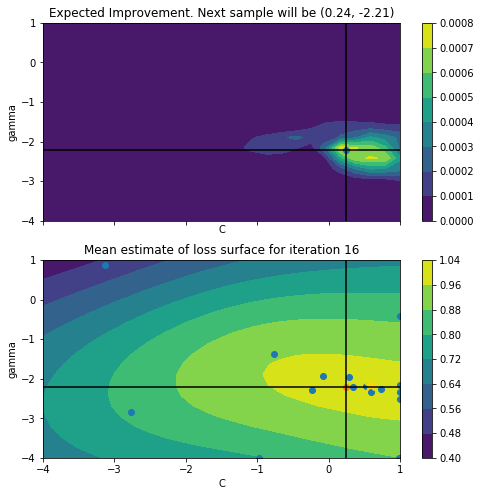

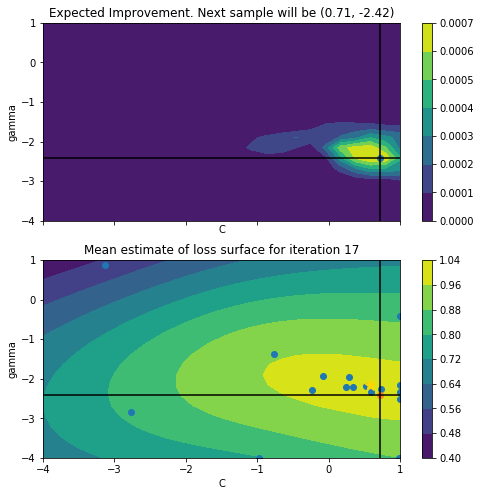

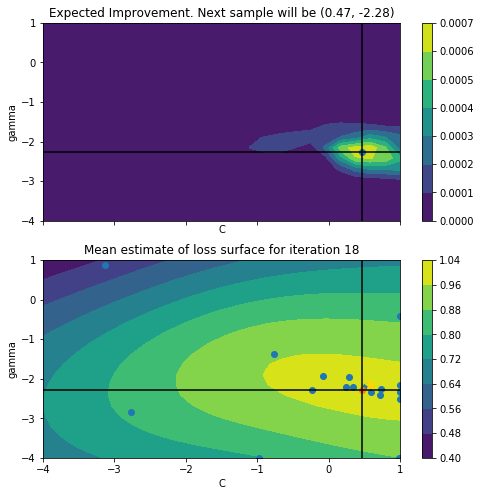

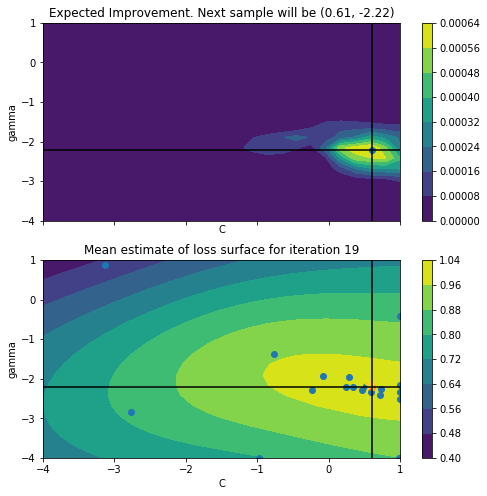

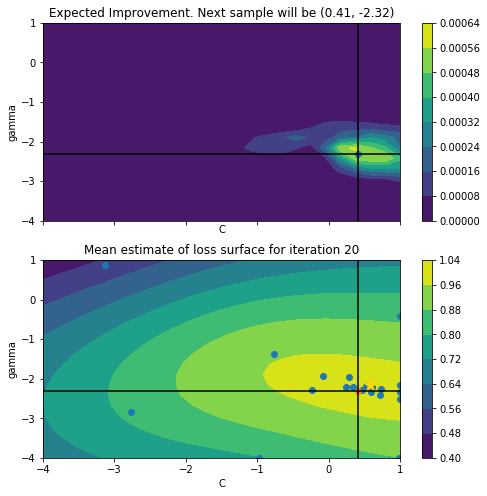

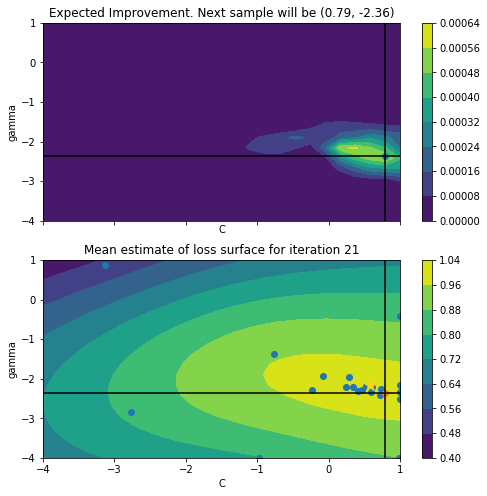

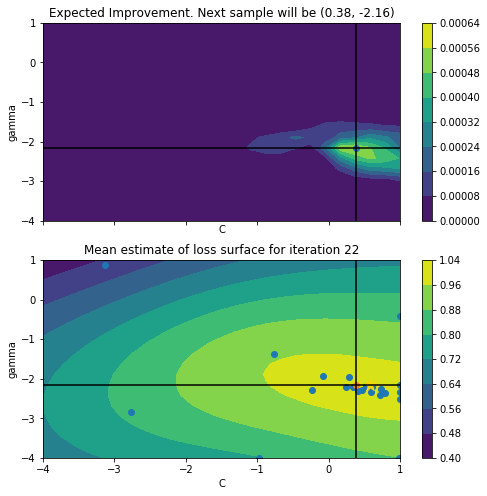

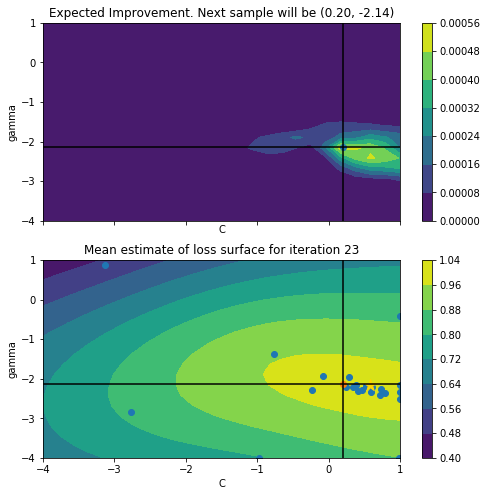

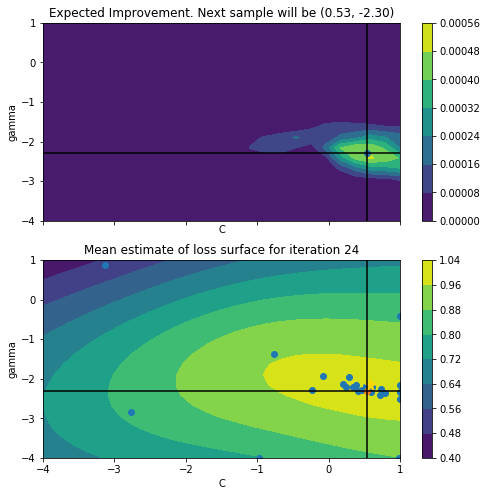

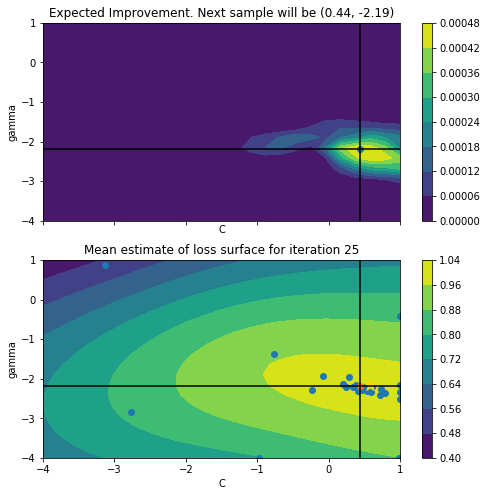

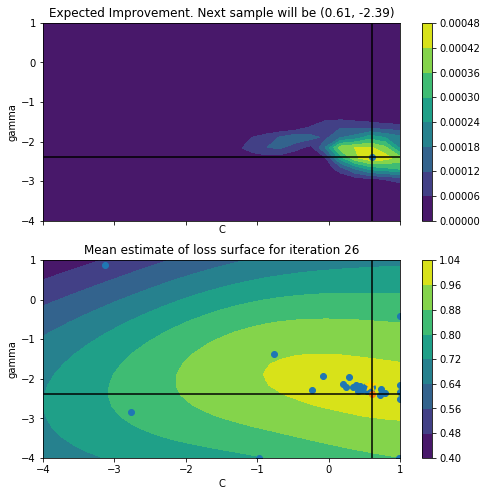

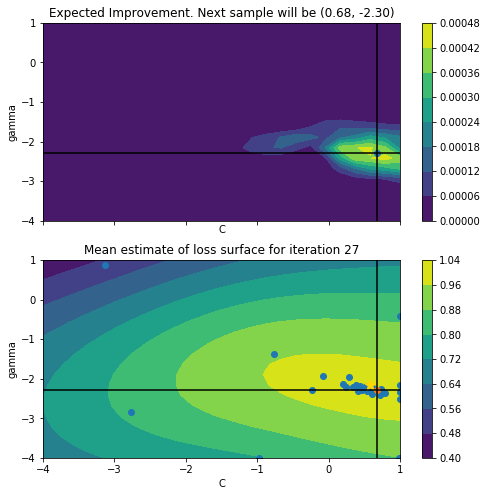

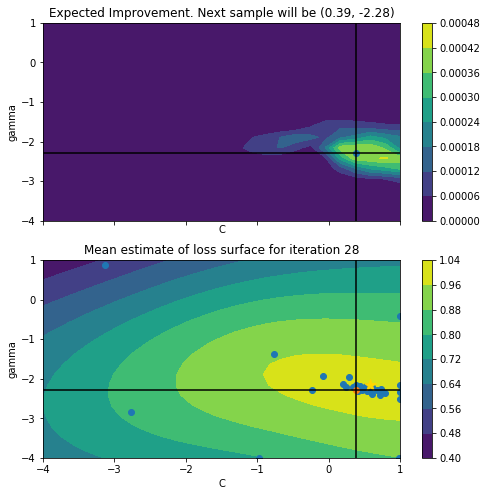

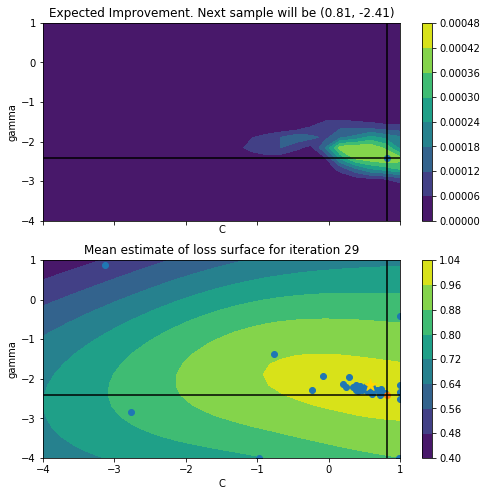

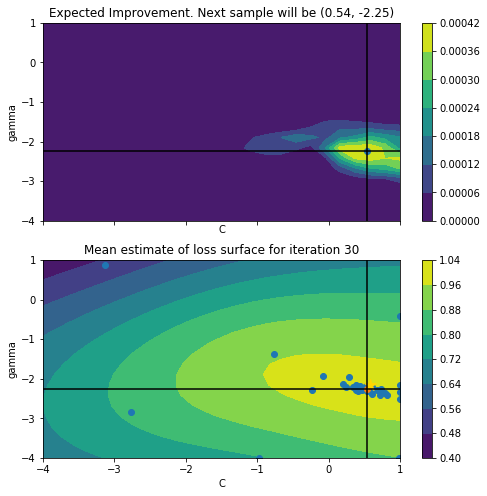

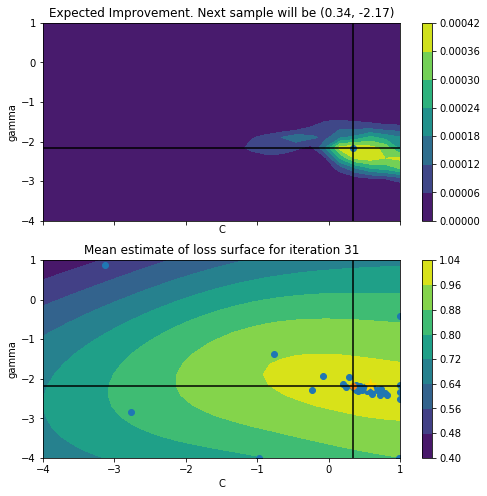

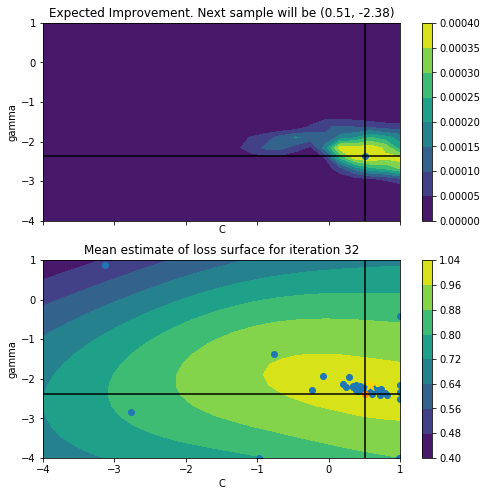

In [47]:
rc('text', usetex=False)
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.58333333, -2.15789474])

## Rastrigin

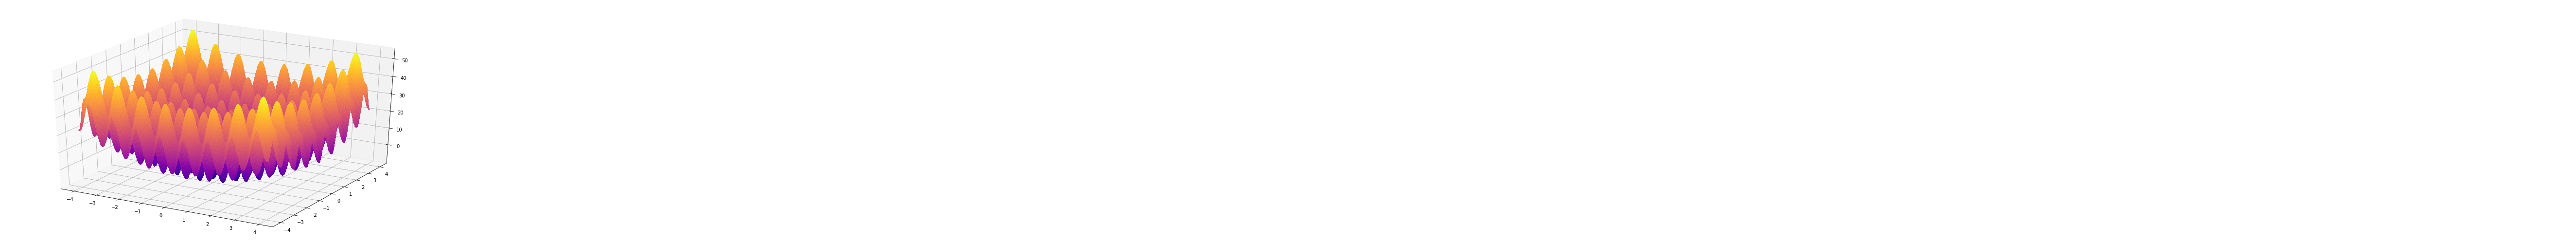

In [3]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt
import numpy as np

def rastrigin(*X, **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])

X = np.linspace(-4, 4, 200)    
Y = np.linspace(-4, 4, 200)    

X, Y = np.meshgrid(X, Y)

Z = rastrigin(X, Y, A=10)

fig = plt.figure(figsize=(16,9))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    
    #plt.savefig('rastrigin.png')
plt.show()

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification

data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

# Кросс-валидационный скор для СВМ функции и параметров переданных в нее
def sample_loss(params):
    return rastrigin(params[0], params[1], A=10)

In [5]:
lambdas = np.linspace(-4, 4, 200) # От 1 до -4, 25 значений
gammas = np.linspace(-4, 4, 200) # От 1 до -4, 20 значений

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas]) # Сетка переборов, 500 значений

real_loss = [sample_loss(params) for params in param_grid] # считаем лосс для каждого

# The maximum is at:
param_grid[np.array(real_loss).argmin(), :]

array([0.0201005, 0.0201005])

In [6]:
param_grid.shape

(40000, 2)

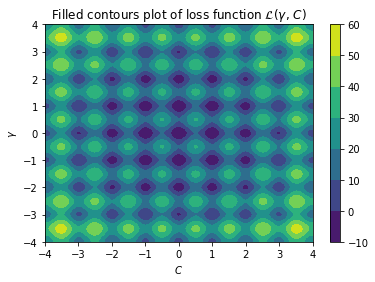

In [7]:
%matplotlib inline

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma$')
plt.show()

In [42]:
bounds = np.array([[-4, 4], [-4, 4]])

xp, yp = bayesian_optimisation(n_iters=50, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=None)#100000)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


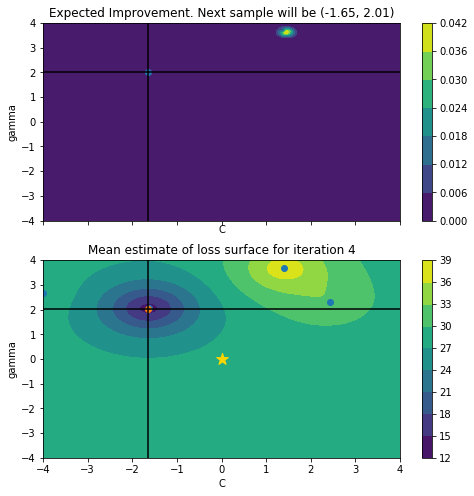

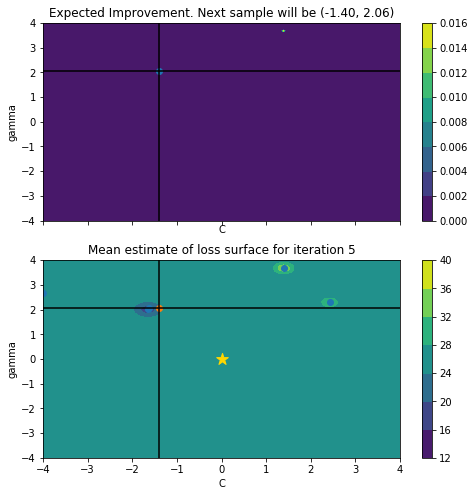

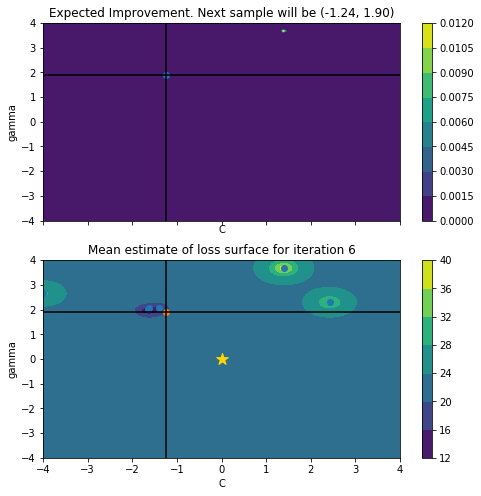

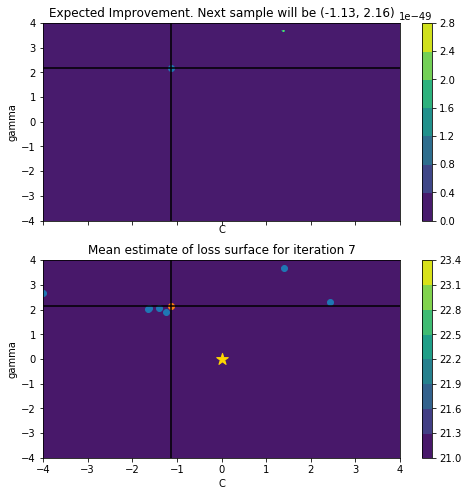

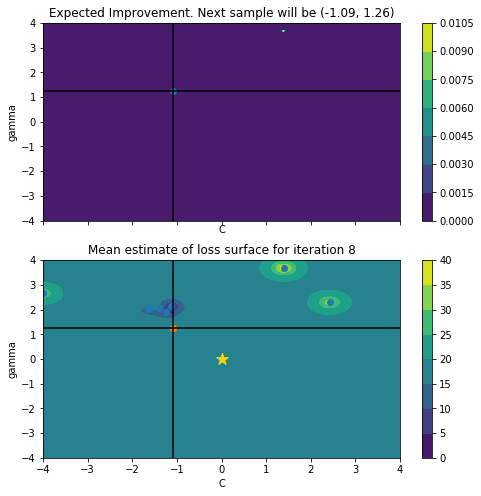

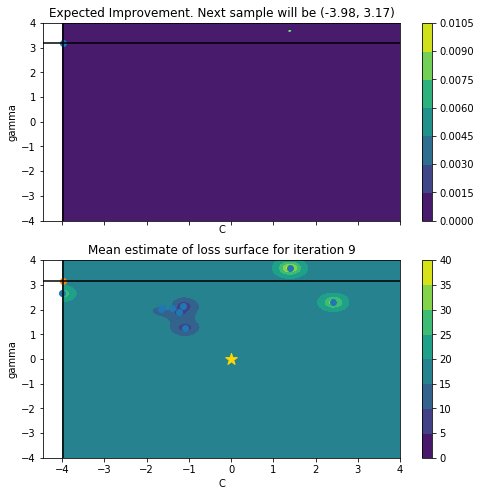

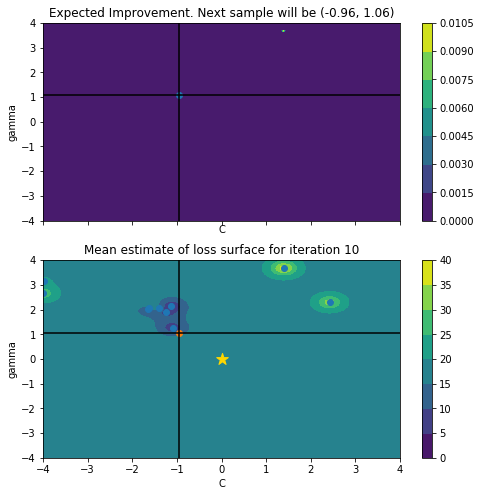

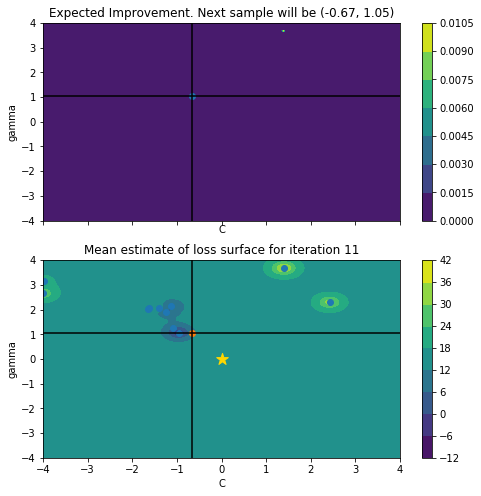

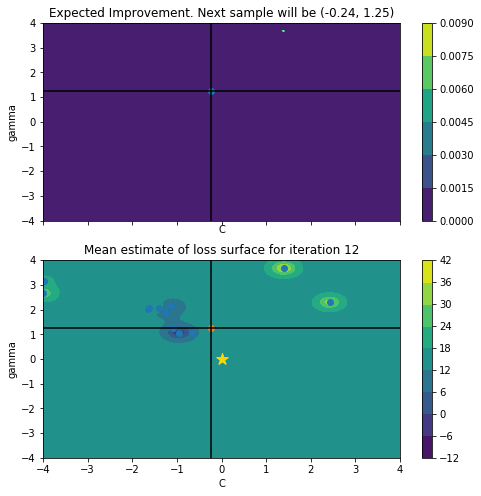

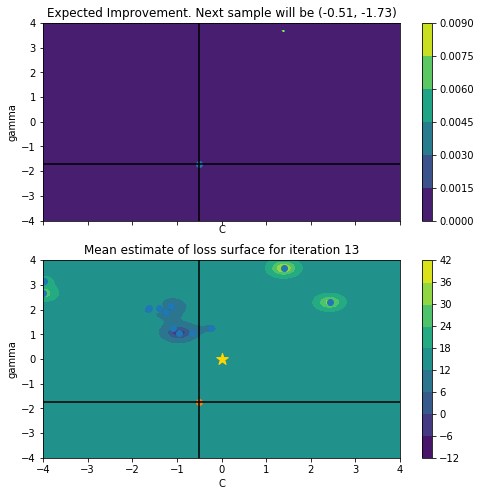

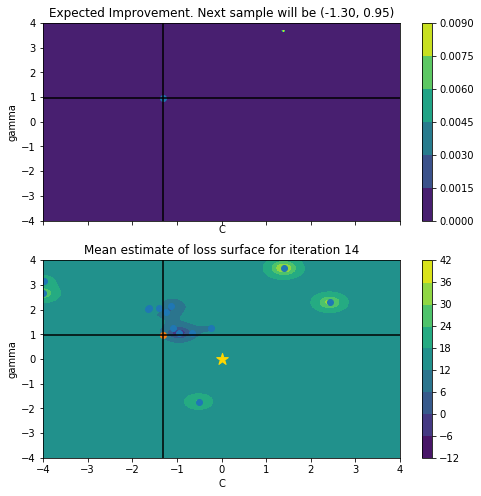

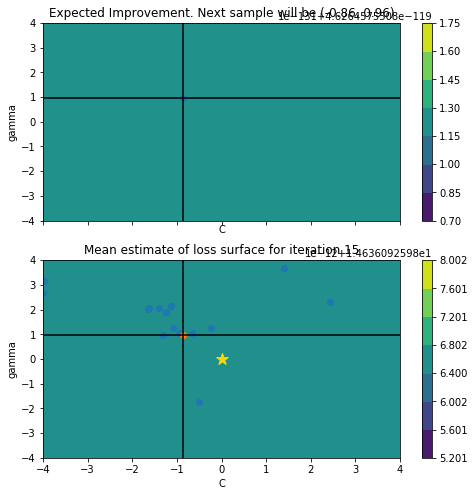

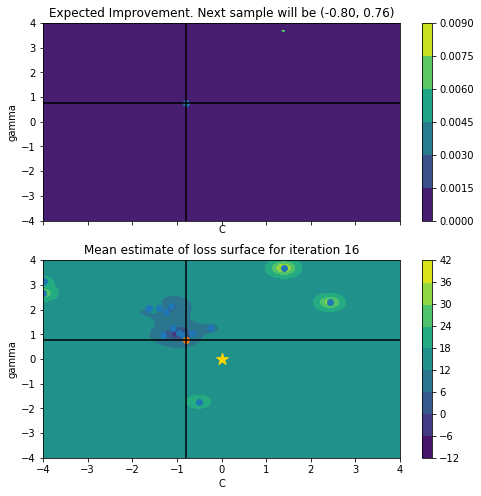

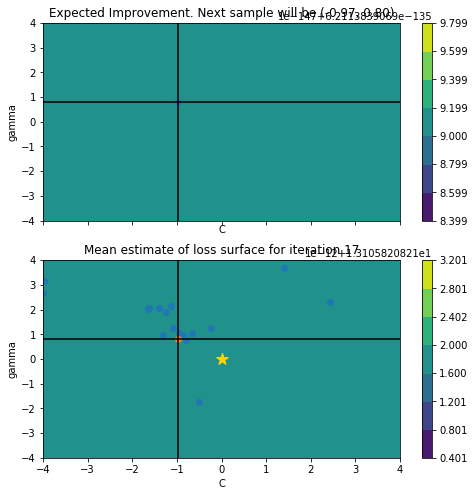

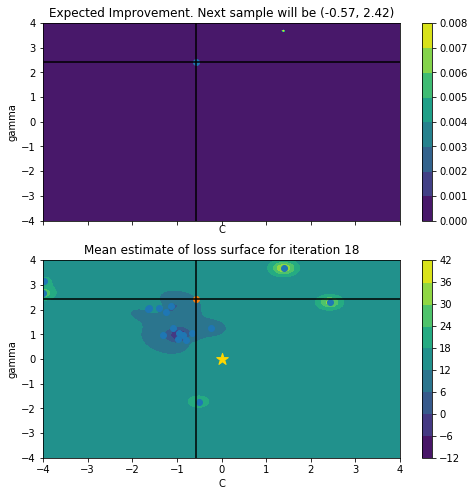

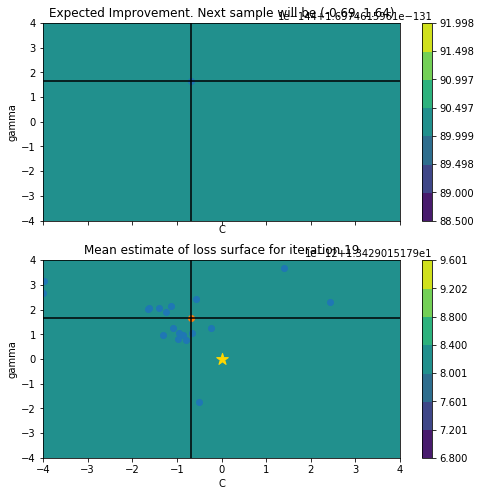

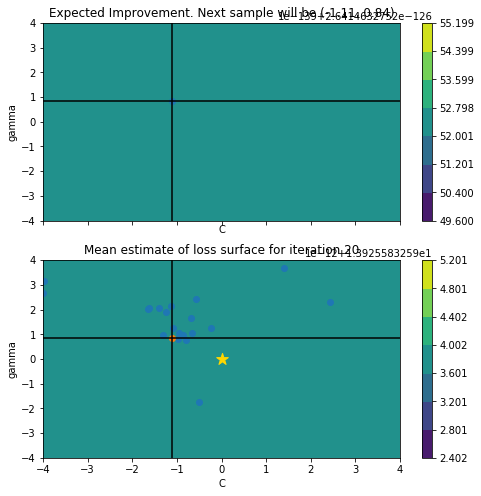

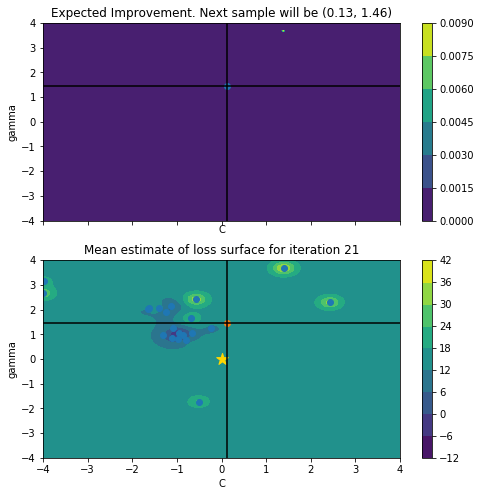

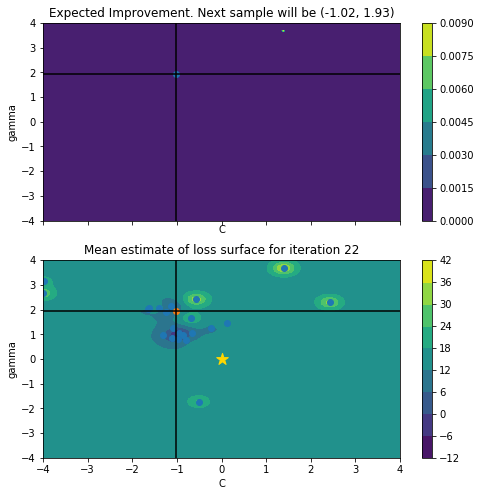

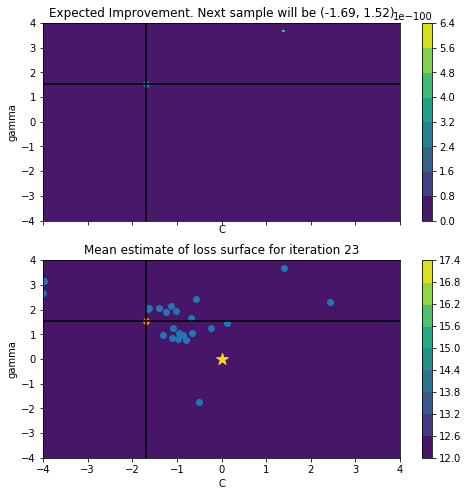

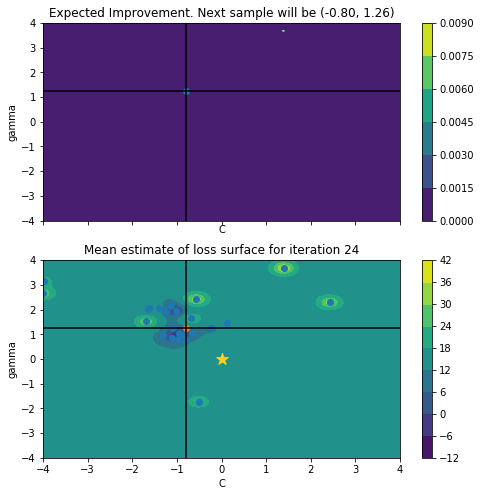

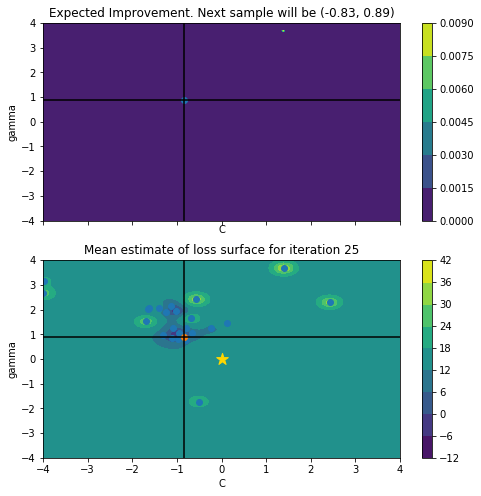

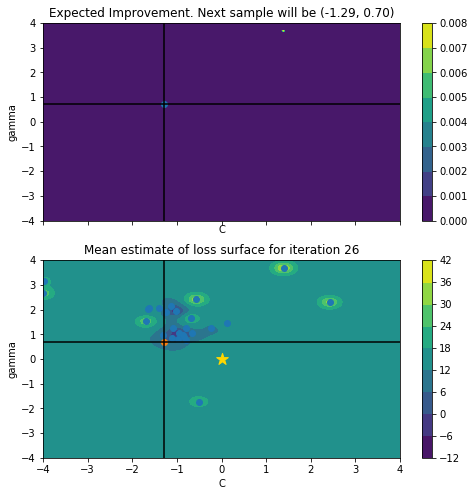

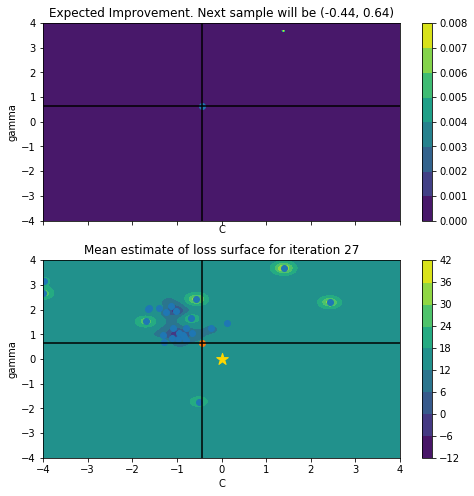

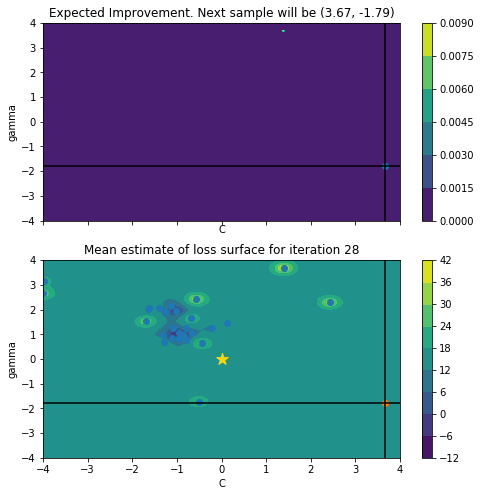

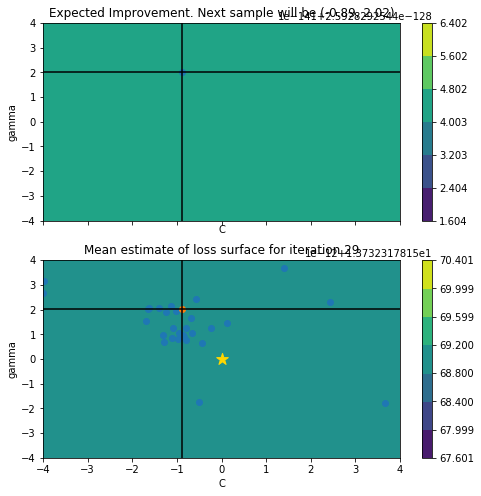

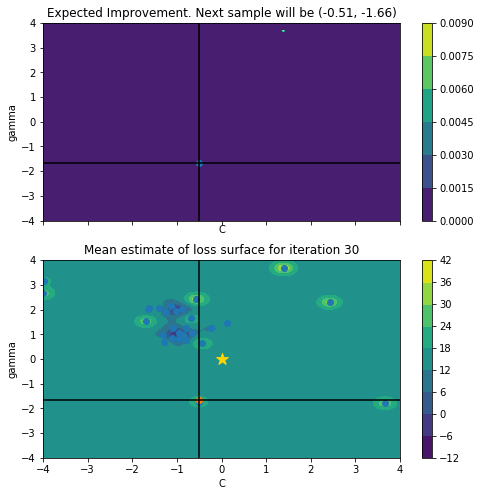

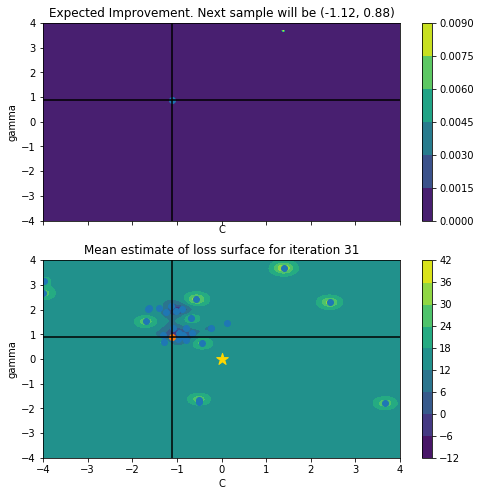

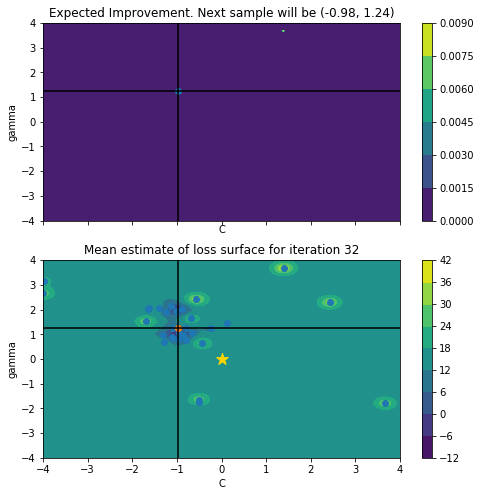

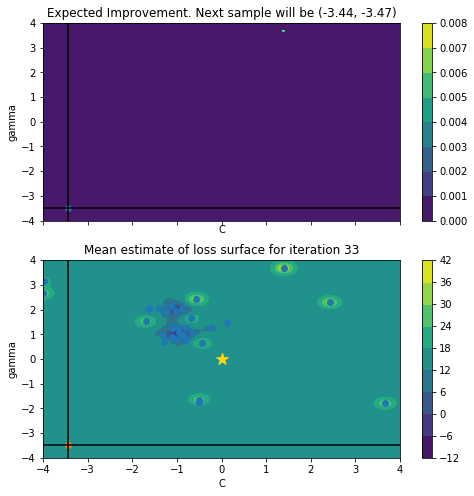

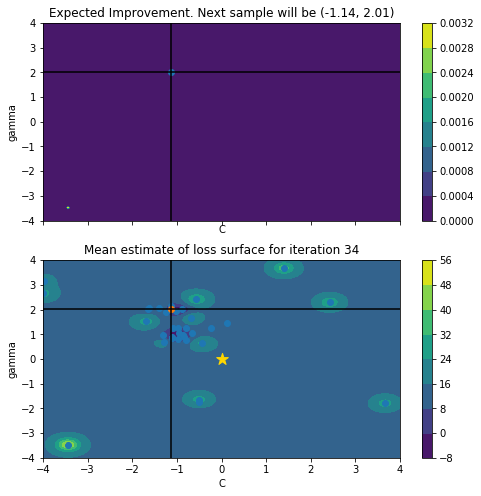

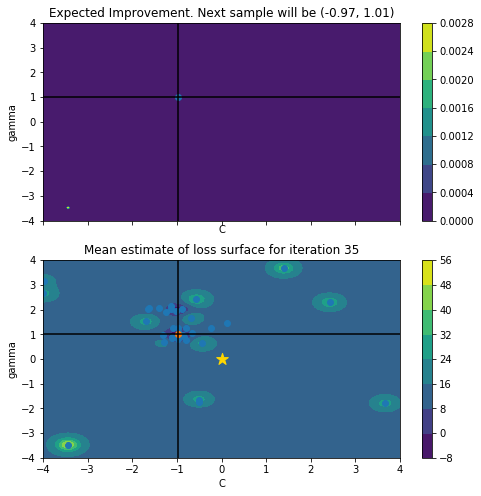

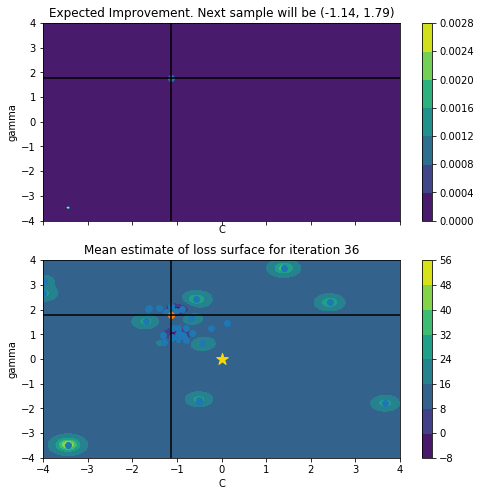

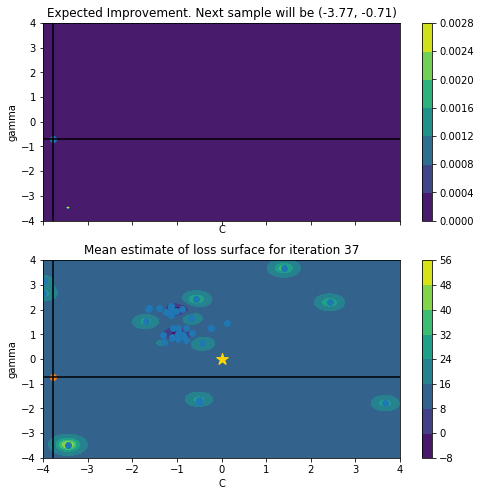

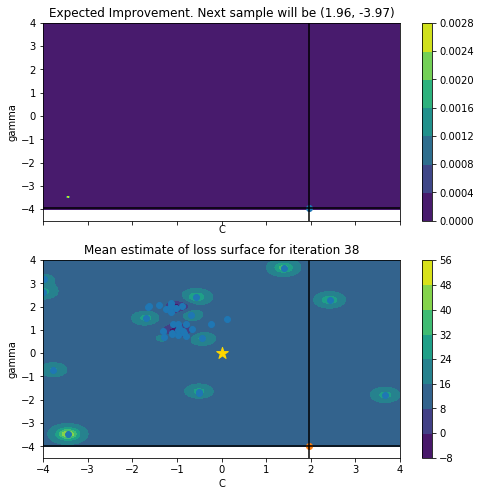

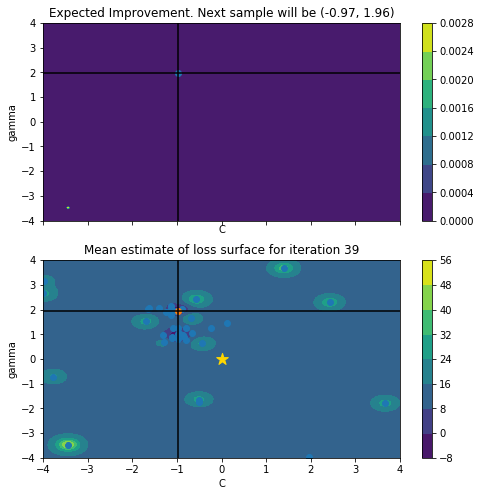

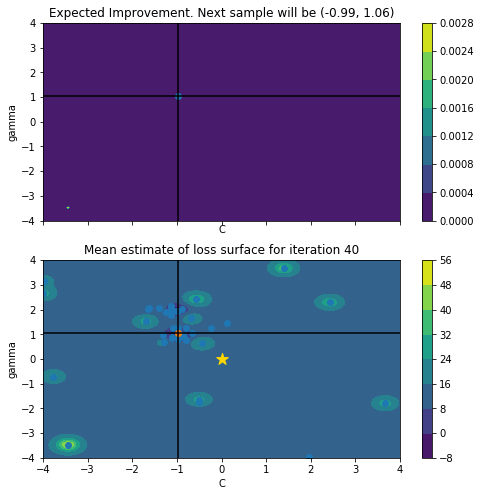

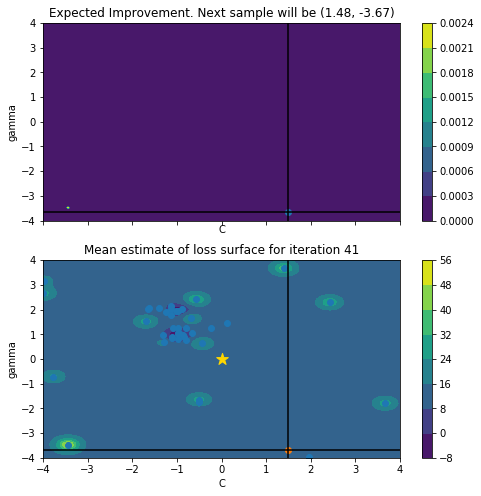

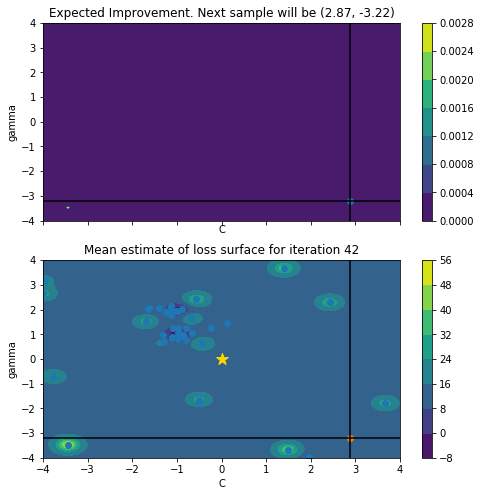

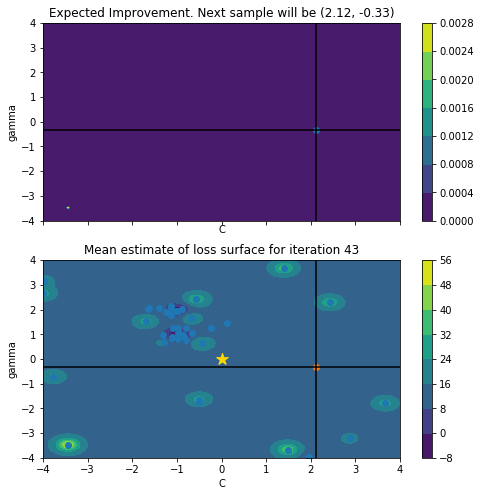

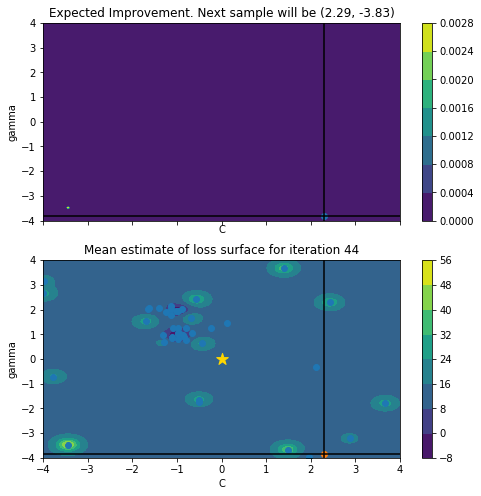

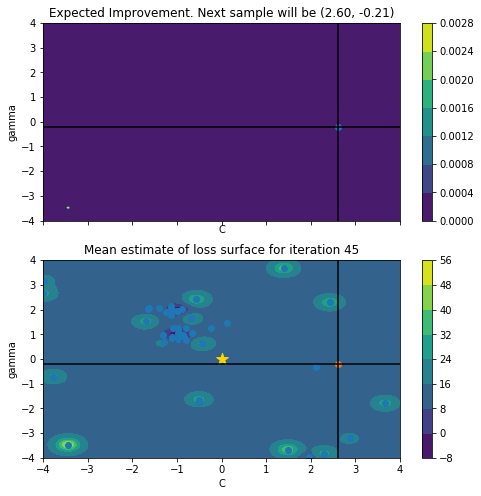

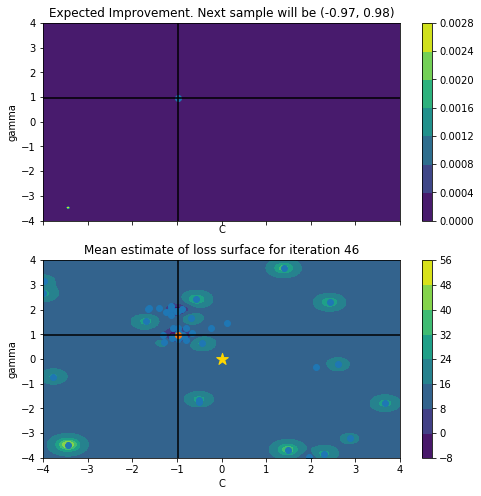

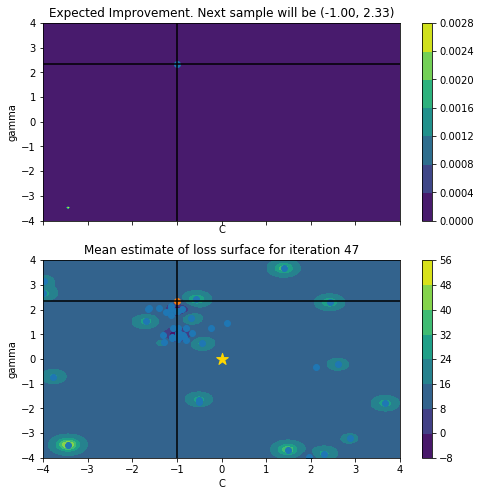

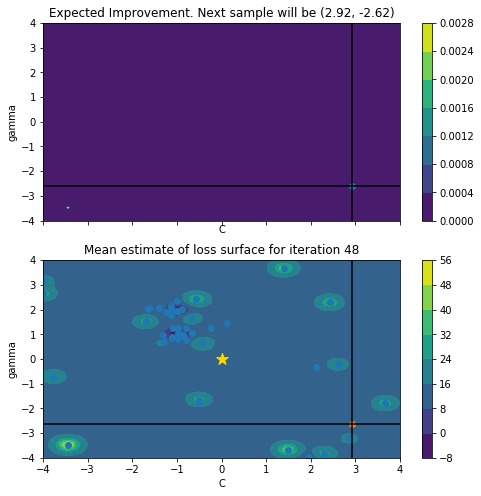

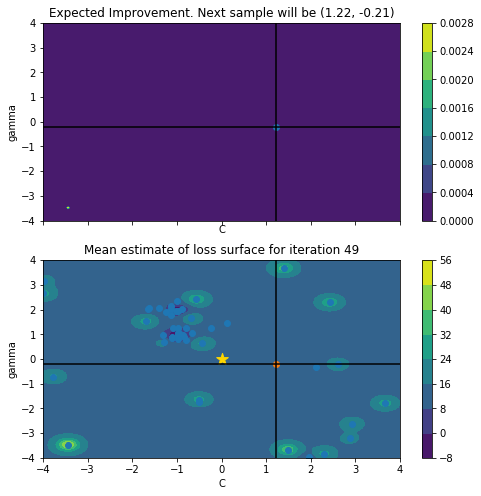

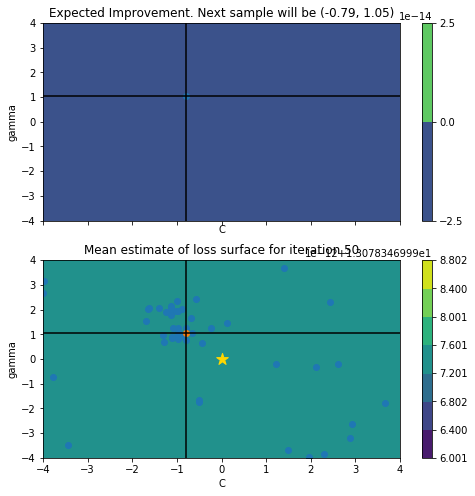

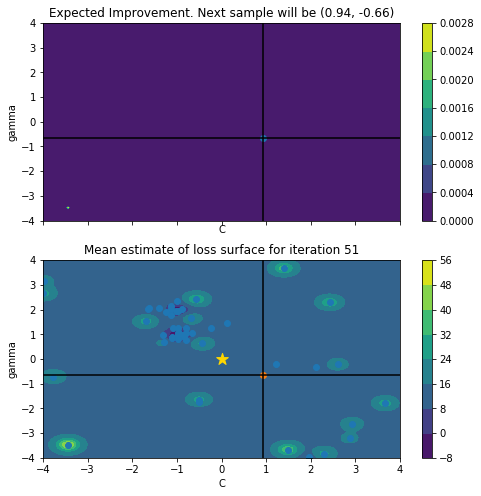

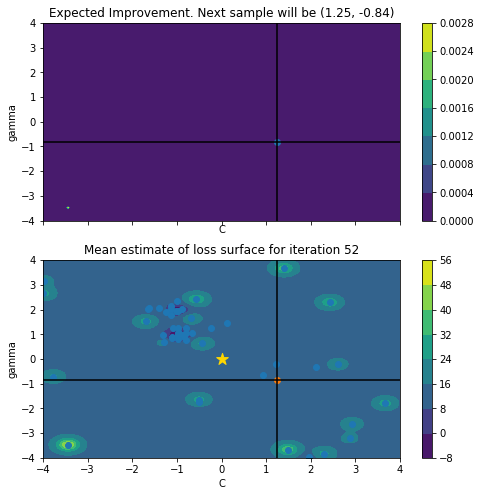

In [43]:
#rc('text', usetex=False)
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0, 0])

## Try RF

In [157]:
""" gp.py
Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement_rf(x, gaussian_process, evaluated_loss, greater_is_better=True, n_params=1):

    x_to_predict = x.reshape(-1, n_params) # бесполезная (разве что ради проверки)
    
    # На той модели предсказываем мю, сигму для x_to_predict
    mu = gaussian_process.predict(x_to_predict)
    
    # Находим оптимальный лосс, из старых значений
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    # if False or 0 == -1, else = 1 - ВЫЕБОНЫ, можно проще
    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero # игнор ошибок
    with np.errstate(divide='ignore'):
        # Считаем З
        Z = scaling_factor * (mu - loss_optimum) 

    return -1 * Z


def bayesian_optimisation_rf(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                             random_search=False, epsilon=1e-4):

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    # Стартовые точки

    for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
        # Делаем параметры, считаем функцию для них
        x_list.append(params)
        y_list.append(sample_loss(params))


    xp = np.array(x_list)
    yp = np.array(y_list)

    
    # Create the RF model
    model = RandomForestRegressor(random_state = 42)

    
    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        # Генерируем (random_search, len(params)) чисел в нашем промежутке
        x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))

        # считаем 100к ЕИ, берем наилучшее
        ei = -1 * expected_improvement_rf(x_random, model, yp, greater_is_better=True, n_params=n_params)
        next_sample = x_random[np.argmax(ei), :]


        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        # Если новая точка ближе на хотя бы епсилон к нашей - выбираем следующую рандомно
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [132]:
""" plotters.py
"""

import numpy as np
import matplotlib.pyplot as plt

def plot_iteration_rf(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):
    """ plot_iteration
    Plots a line plot (1D) or heatmap (2D) of the estimated loss function and expected
    improvement acquisition function for each iteration of the Bayesian search algorithm.
    Arguments:
    ----------
        first_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the first parameter.
        sampled_params: array-like, shape = [n_points, n_params]
            Points for which the value of the loss function is computed.
        sampled_loss: function.
            Values of the loss function for the parameters in `sampled_params`.
        first_iter: int.
            Only plot iterations after the `first_iter`-th iteration.
        alpha: float
            Variance of the error term in the GP model.
        greater_is_better: boolean
            Boolean indicating whether we want to maximise or minimise the loss function.
        true_y: array-like, shape = [n, 1] or None
            Array containing the true value of the loss function. If None, the real loss
            is not plotted. (1-dimensional case)
        second_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the second parameter, in case
            of a heatmap.
        param_dims_to_plot: list of length 2
            List containing the indices of `sampled_params` that contain the first and
            second parameter.
        optimum: array-like [1, n_params].
            Maximum value of the loss function.
    """

    # Create the GP
    model = RandomForestRegressor(random_state = 42)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu = model.predict(first_param_grid[:, np.newaxis])
            ei = -1 * expected_improvement_rf(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)
            #print('1d')
            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], 
                                          mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu = model.predict(param_grid)
            ei = -1 * expected_improvement_rf(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)
            #print('2d')
            fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, 
                                          sampled_params[:(i+1), param_dims_to_plot], sampled_loss, 
                                          mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        #if file_path is not None:
        #    plt.savefig('%s/bo_iteration_%d.png' % (filepath, i), bbox_inches='tight')


def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2


def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("C")
    ax1.set_ylabel("gamma")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("C")
    ax2.set_ylabel("gamma")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='gold', s=150)

    return fig, ax1, ax2

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification

data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

# Кросс-валидационный скор для СВМ функции и параметров переданных в нее
def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

## Grid plot

In [134]:
lambdas = np.linspace(1, -4, 25) # От 1 до -4, 25 значений
gammas = np.linspace(1, -4, 20) # От 1 до -4, 20 значений

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas]) # Сетка переборов, 500 значений

real_loss = [sample_loss(params) for params in param_grid] # считаем лосс для каждого

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

array([ 0.58333333, -2.42105263])

In [135]:
param_grid.shape

(500, 2)

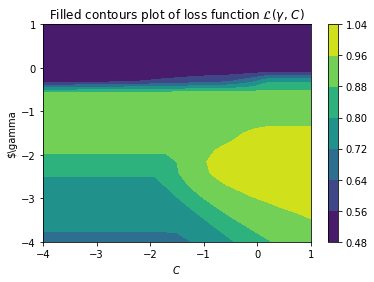

In [136]:
%matplotlib inline

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma')
plt.show()

## SMBO

In [158]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation_rf(n_iters=50, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=10000)

/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until

/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until

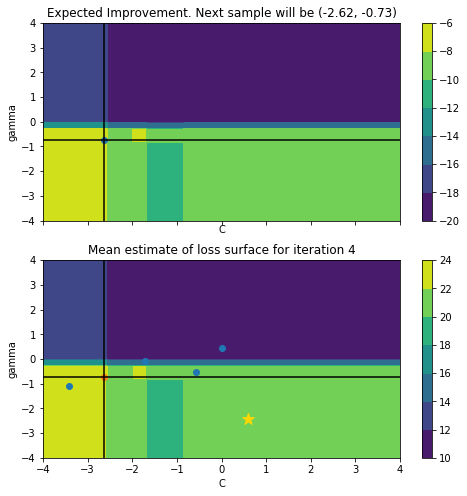

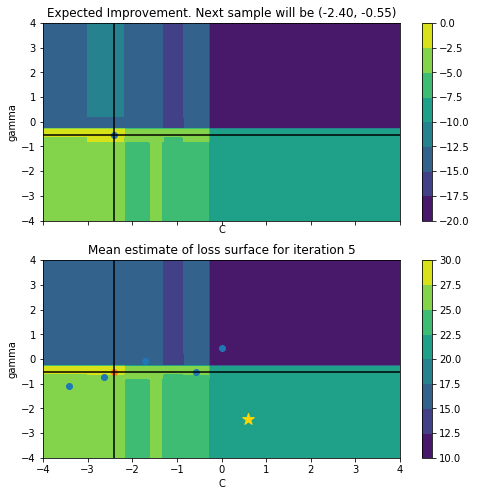

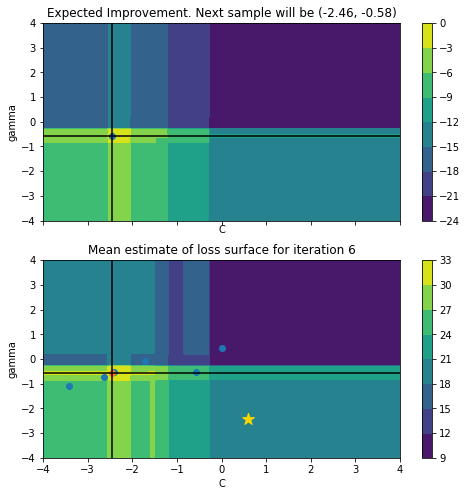

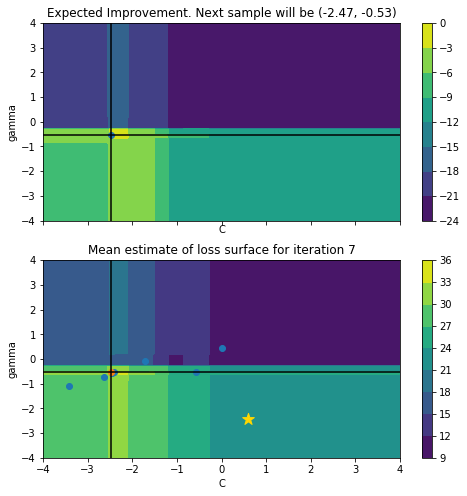

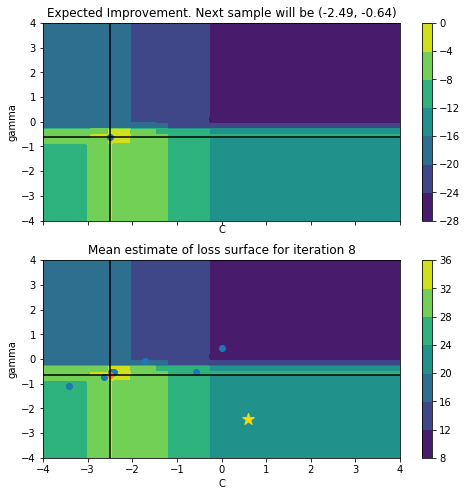

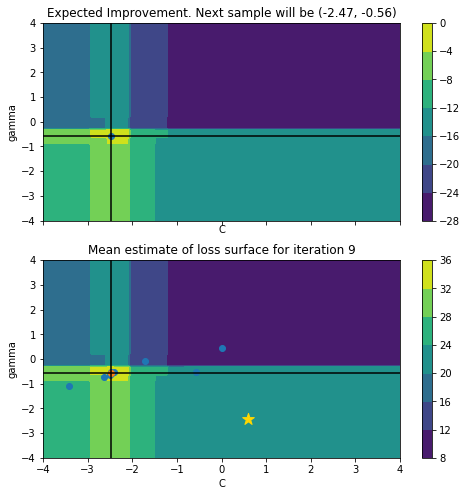

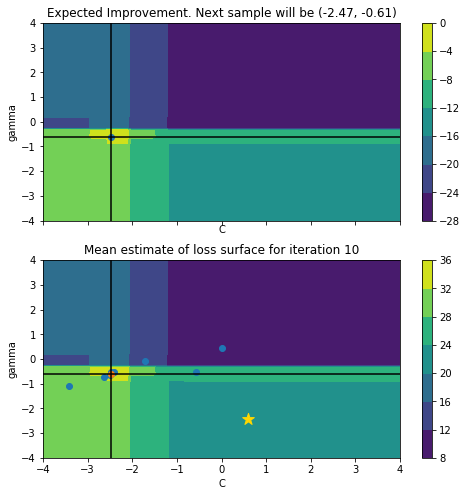

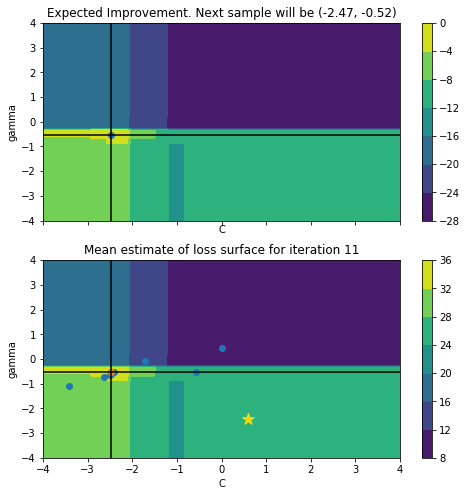

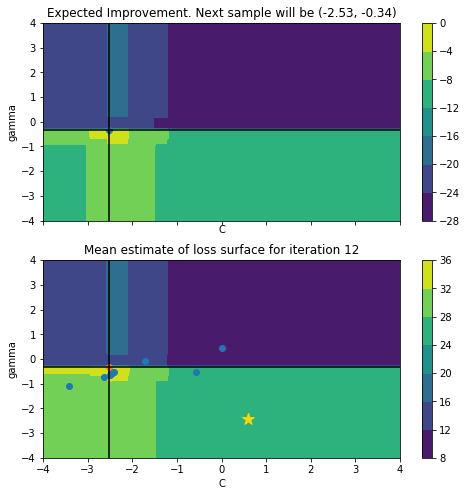

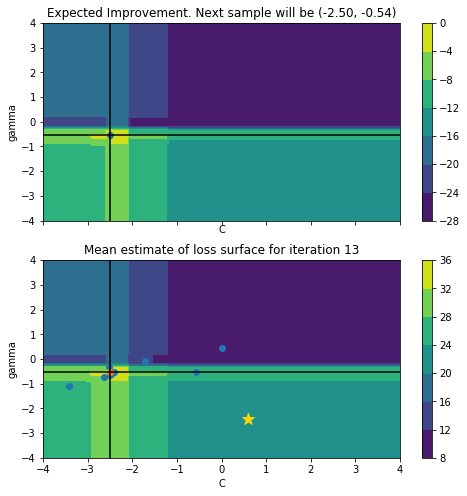

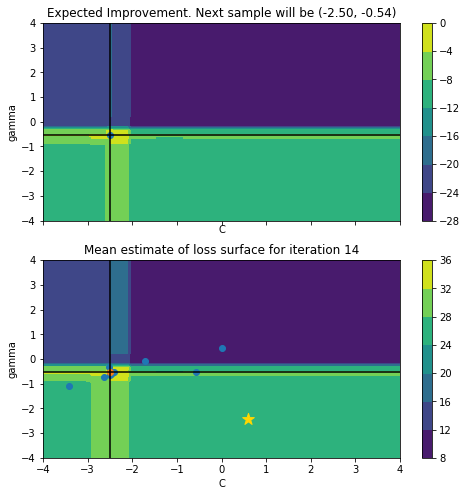

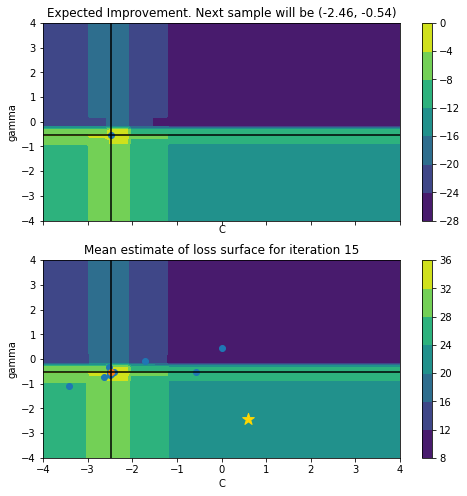

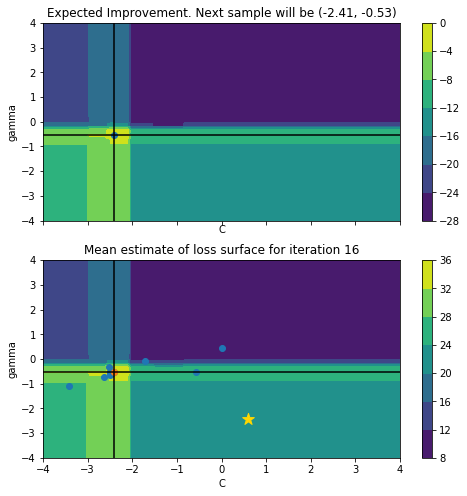

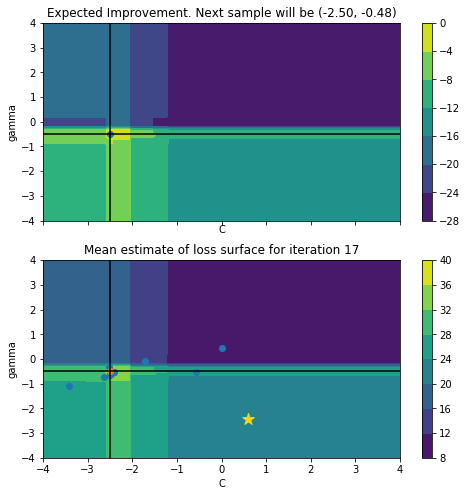

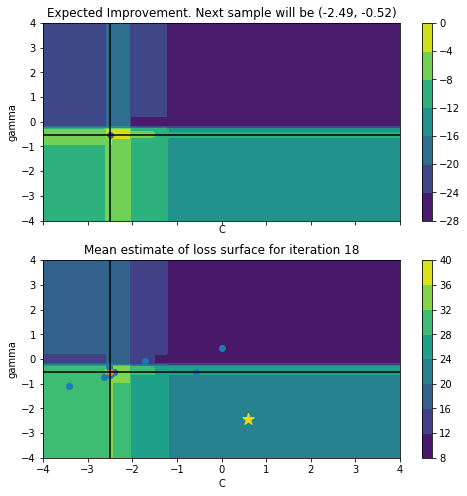

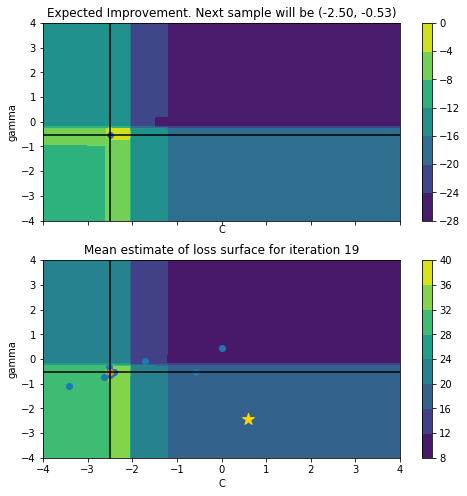

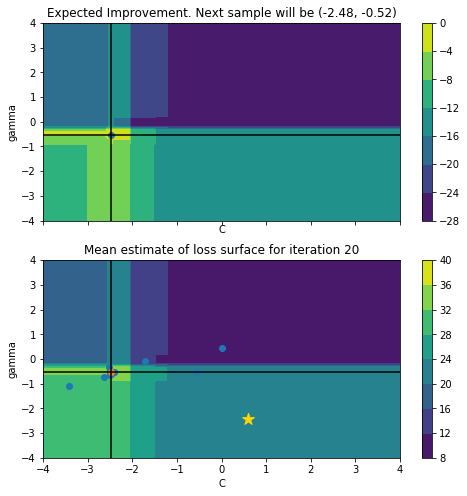

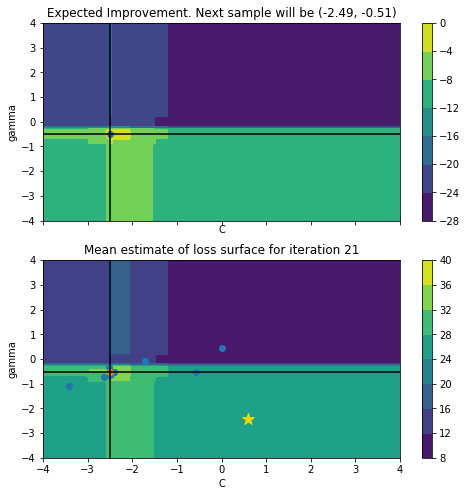

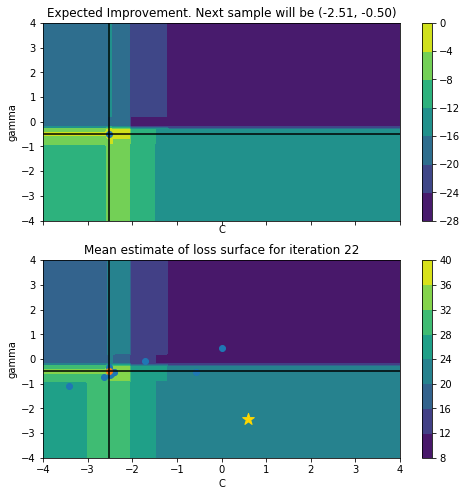

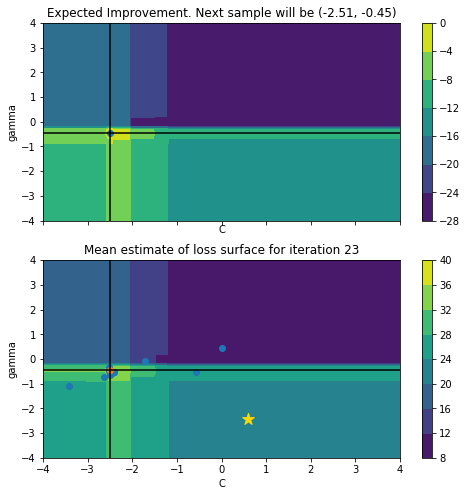

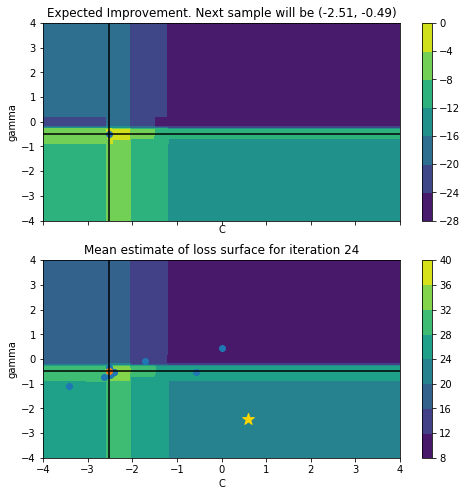

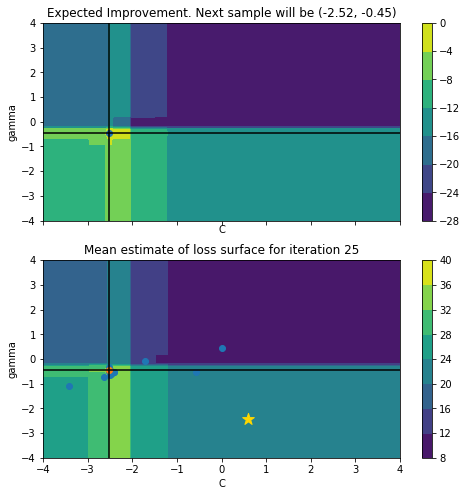

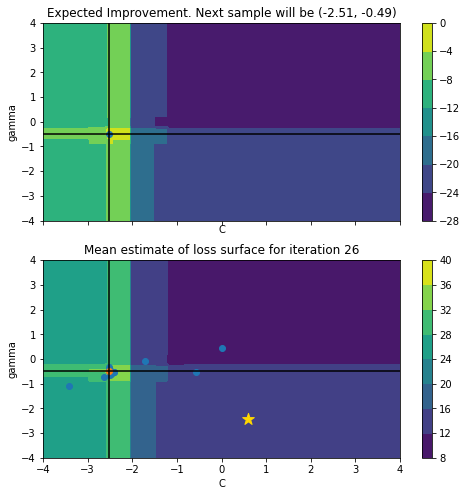

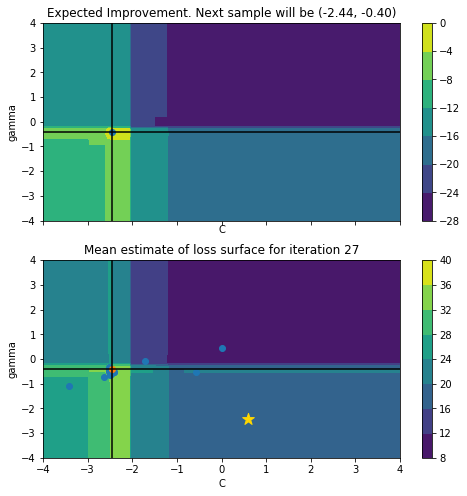

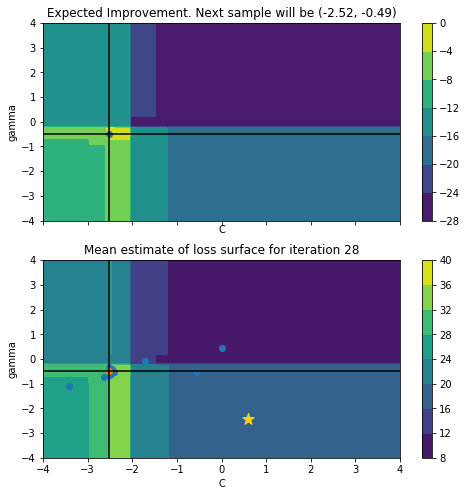

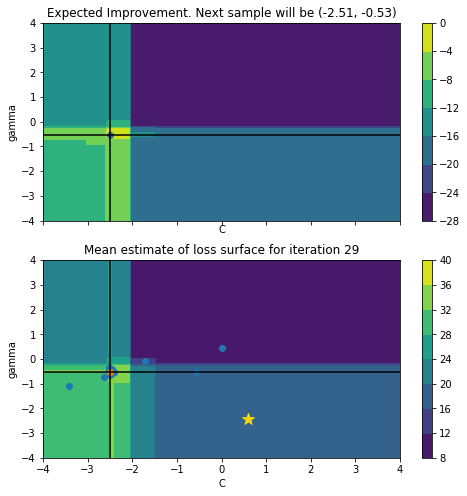

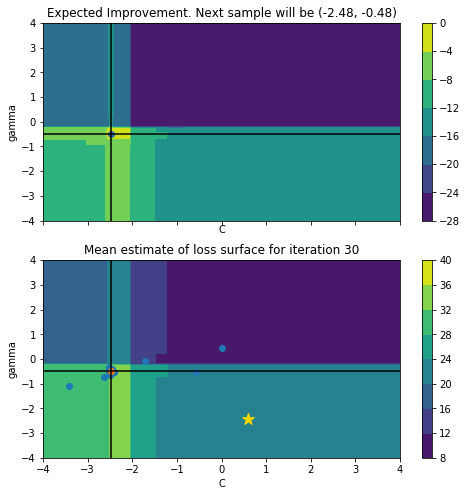

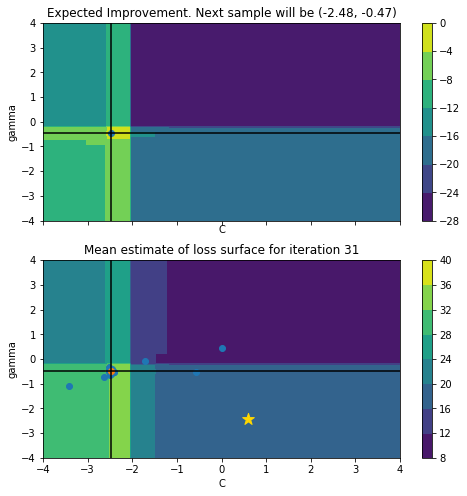

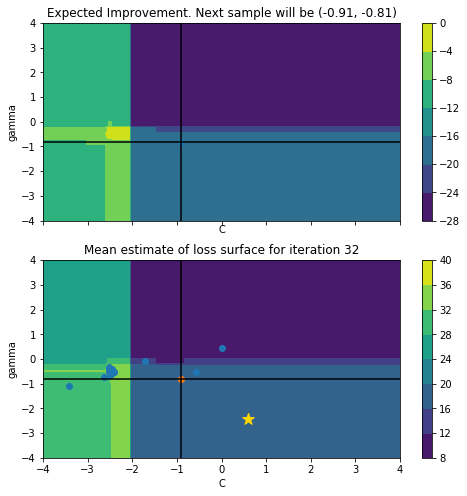

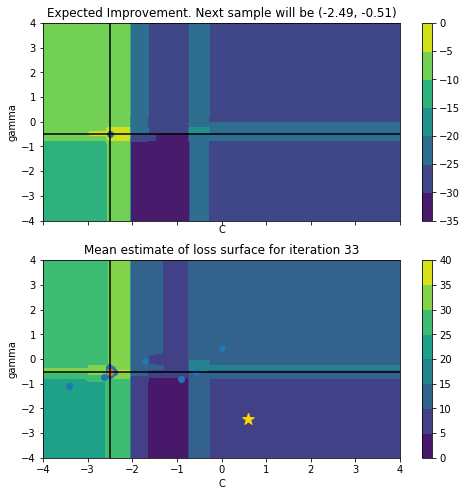

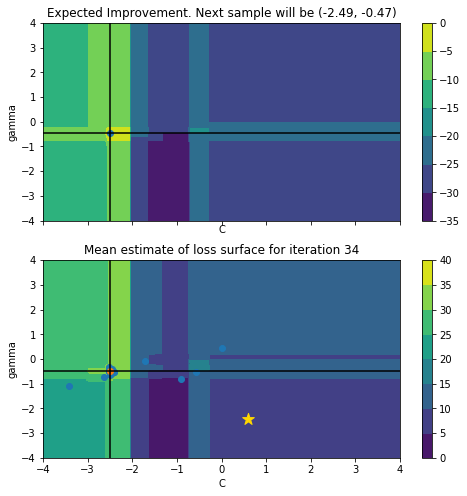

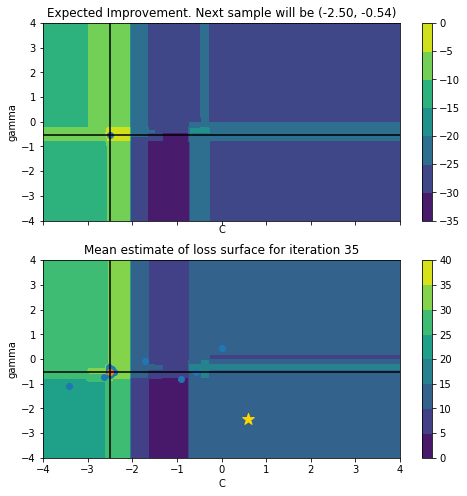

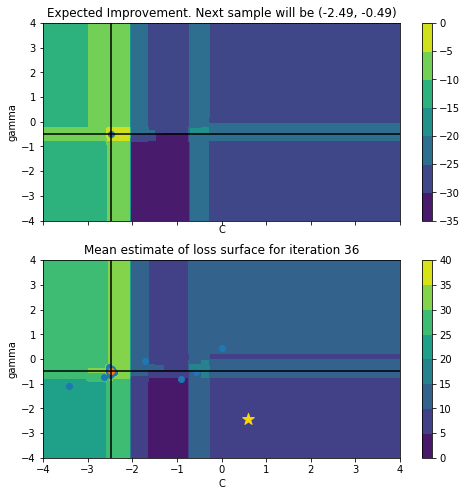

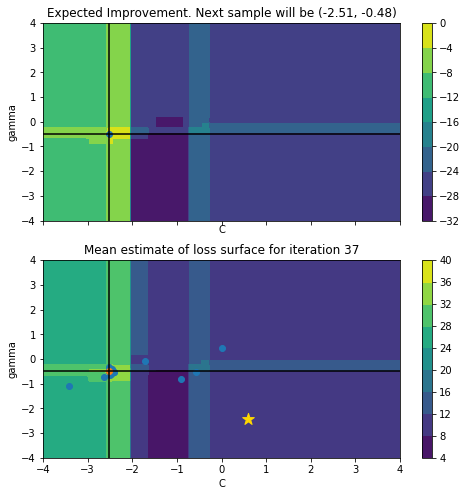

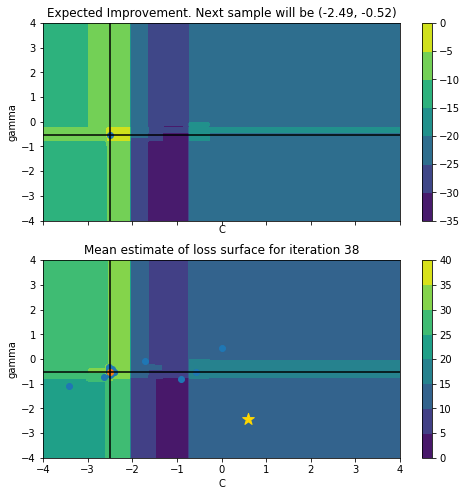

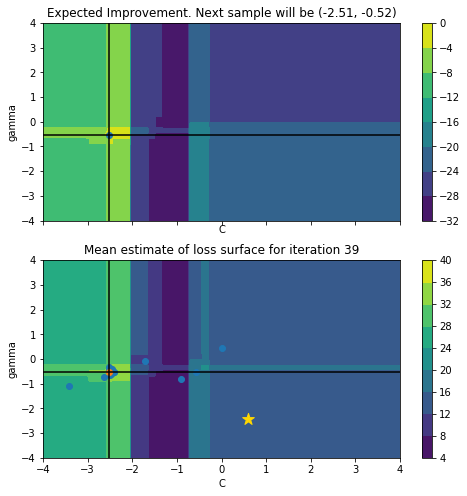

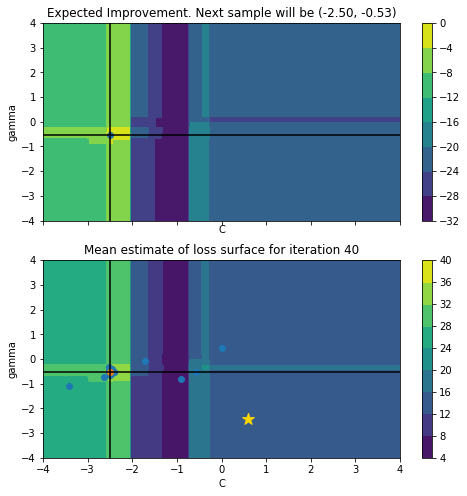

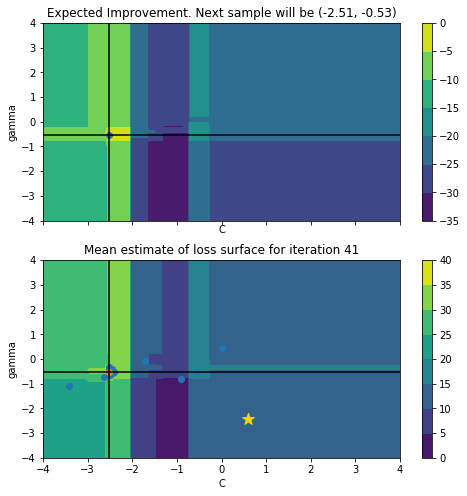

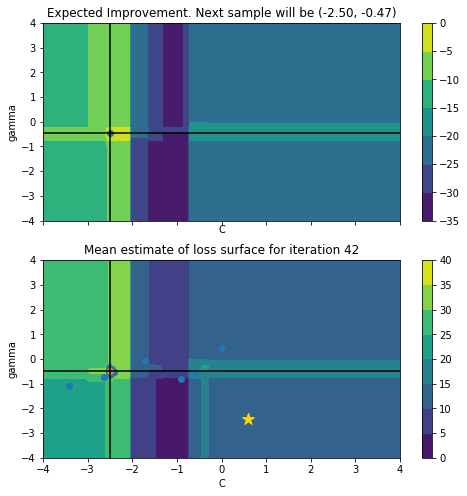

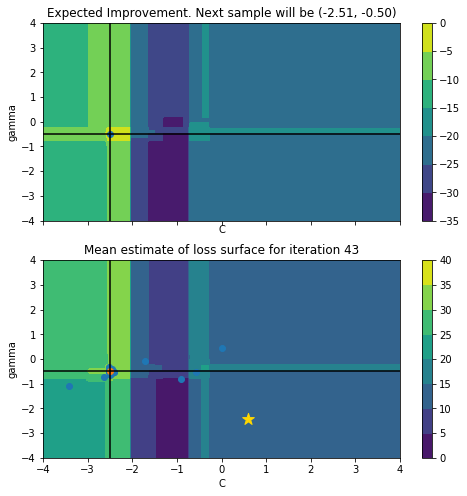

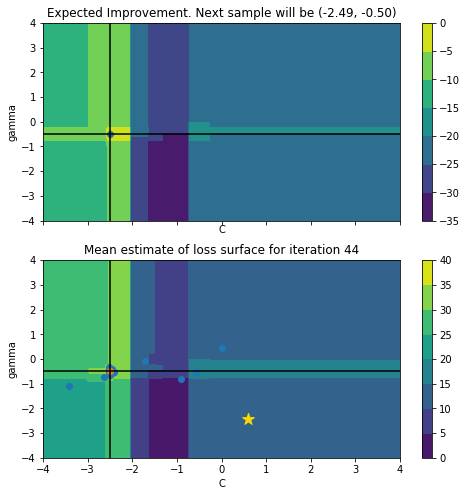

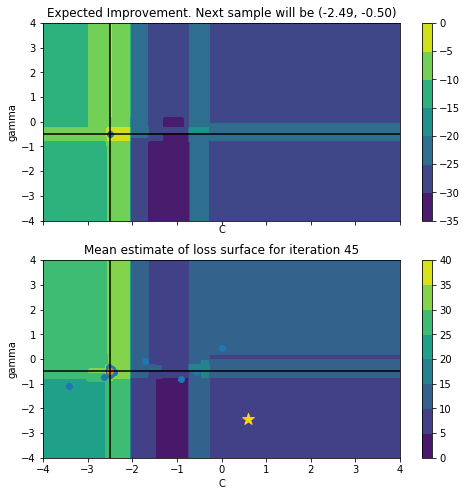

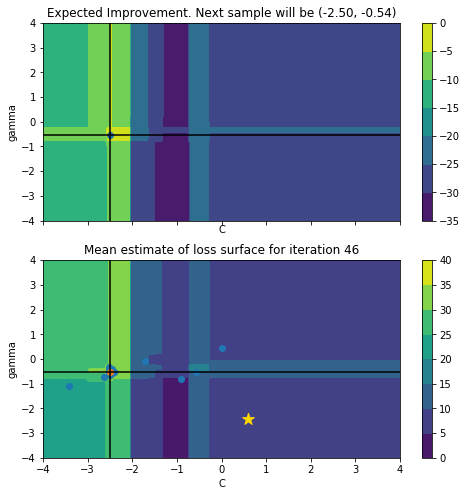

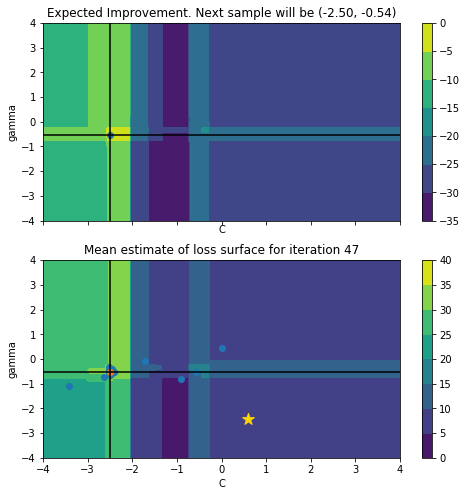

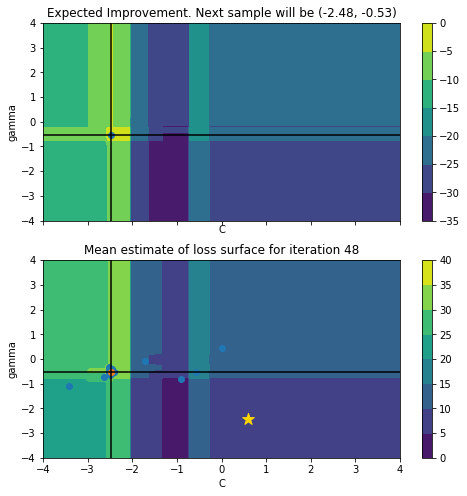

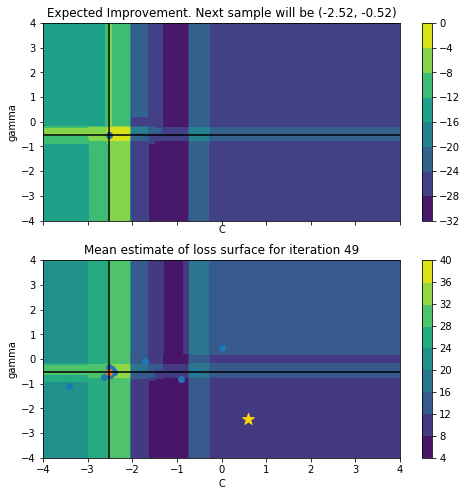

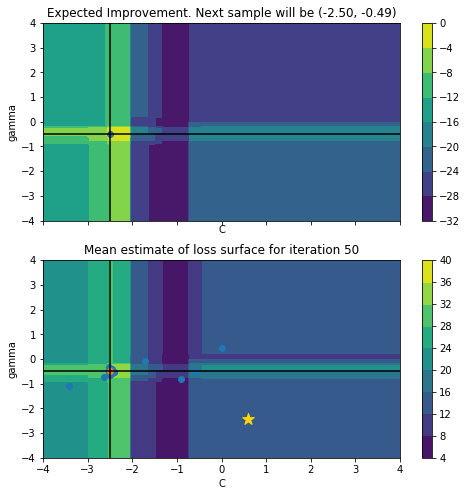

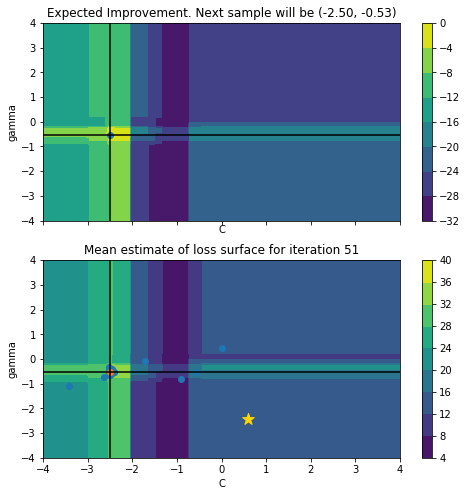

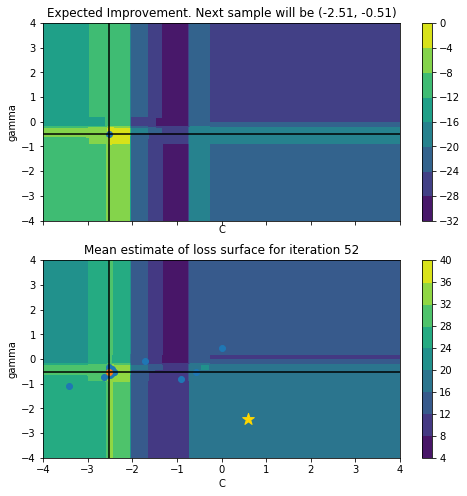

In [159]:
%matplotlib inline
#rc('text', usetex=False)
plot_iteration_rf(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.58333333, -2.42105263])

## Rastrigin

In [153]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification

def rastrigin(*X, **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])
# Кросс-валидационный скор для СВМ функции и параметров переданных в нее
def sample_loss(params):
    return rastrigin(params[0], params[1], A=10)

In [154]:
lambdas = np.linspace(-4, 4, 200) # От 1 до -4, 25 значений
gammas = np.linspace(-4, 4, 200) # От 1 до -4, 20 значений

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas]) # Сетка переборов, 500 значений

real_loss = [sample_loss(params) for params in param_grid] # считаем лосс для каждого

# The maximum is at:
param_grid[np.array(real_loss).argmin(), :]

array([0.0201005, 0.0201005])

In [155]:
param_grid.shape

(40000, 2)

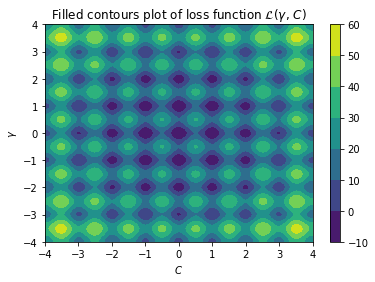

In [156]:
%matplotlib inline

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma$')
plt.show()

In [42]:
bounds = np.array([[-4, 4], [-4, 4]])

xp, yp = bayesian_optimisation_rf(n_iters=50, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=10000)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


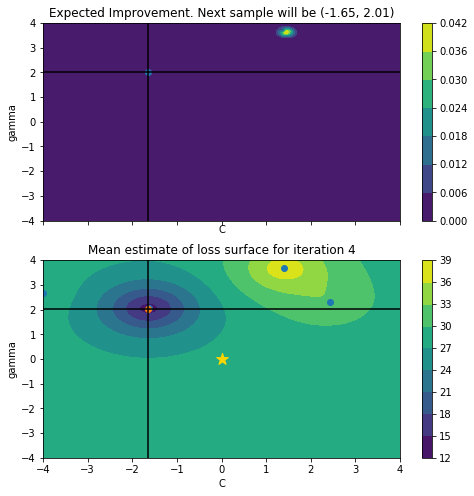

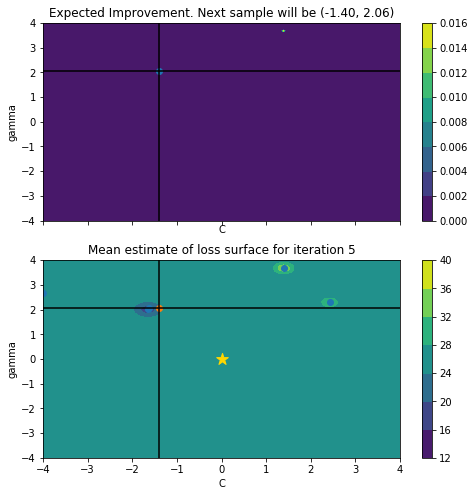

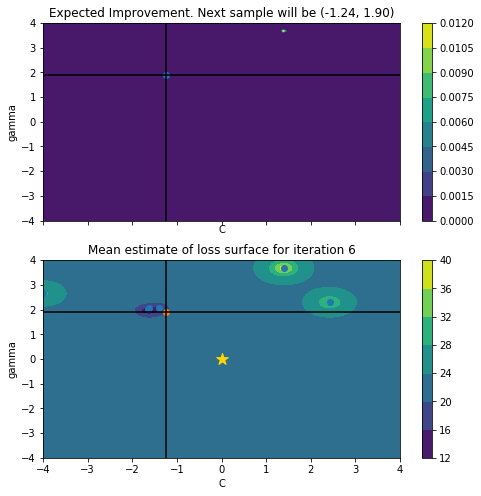

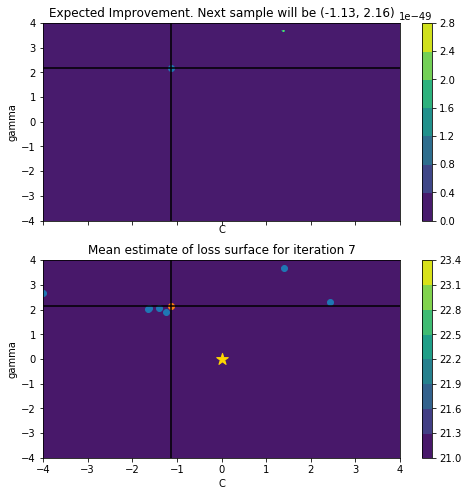

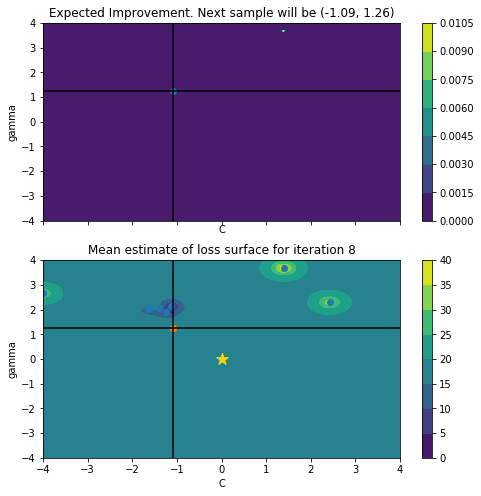

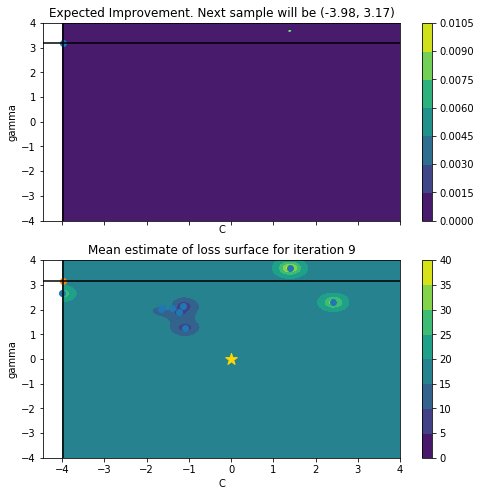

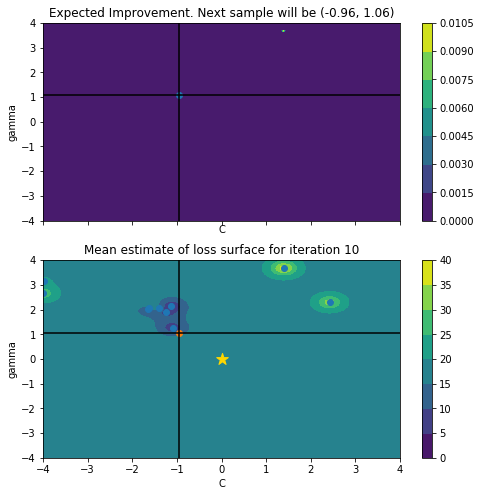

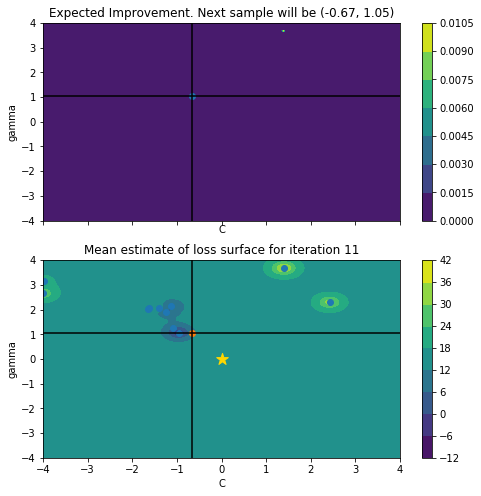

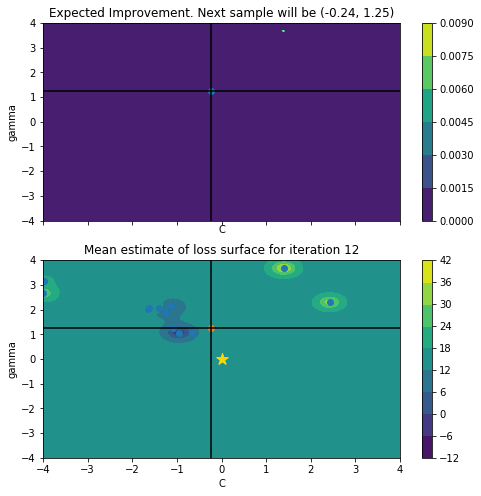

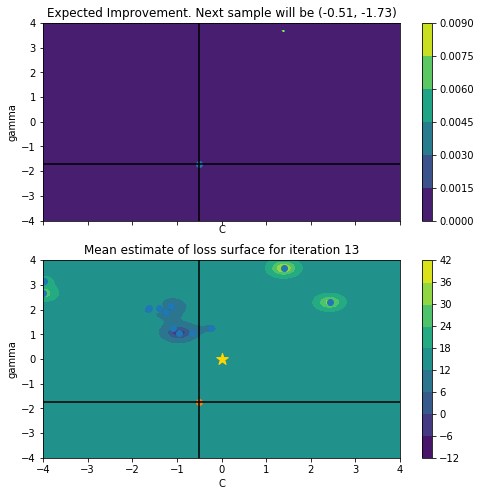

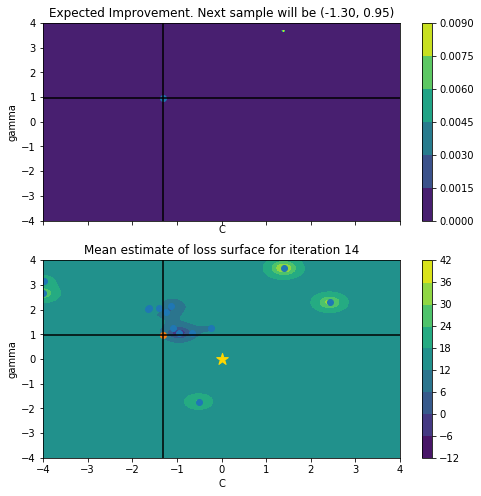

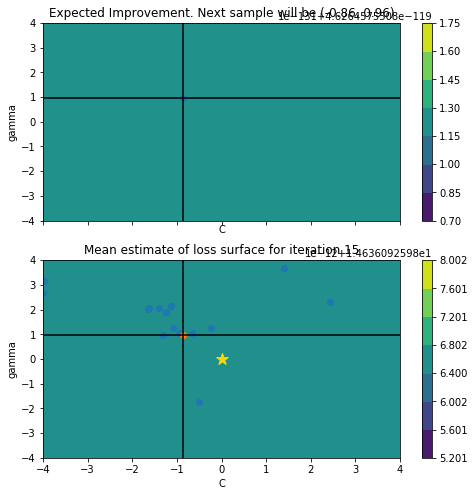

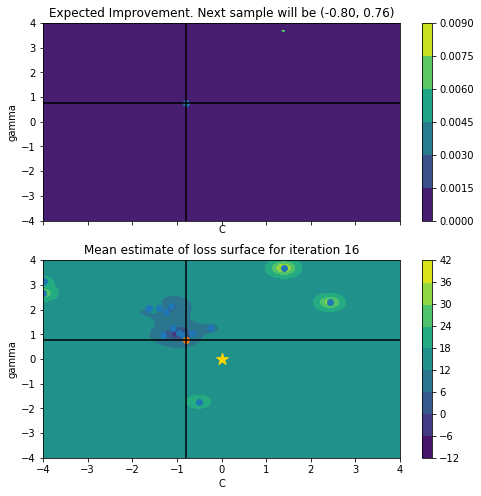

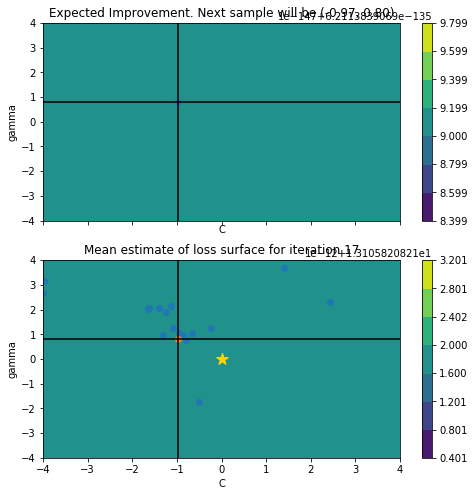

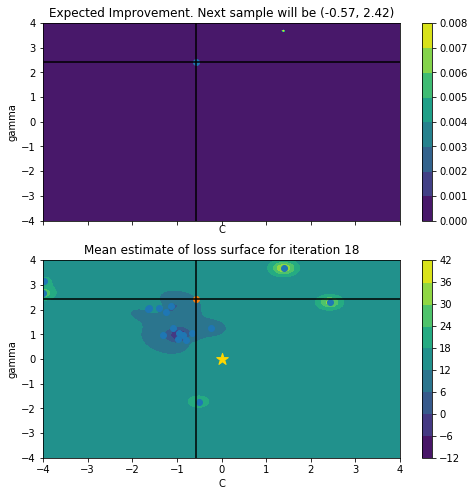

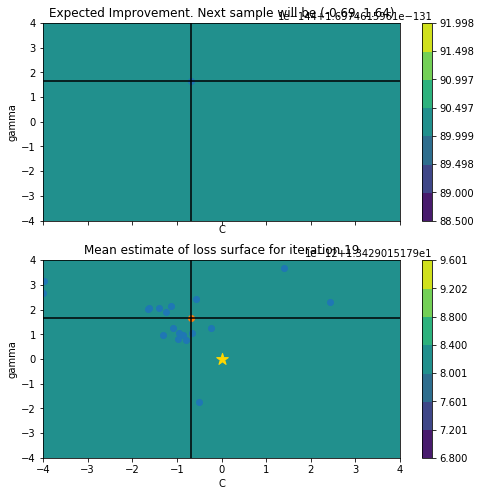

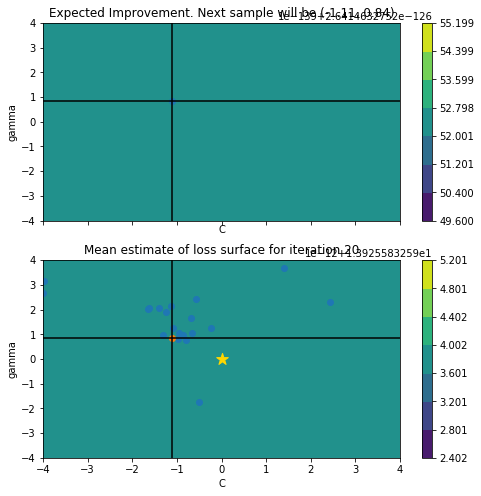

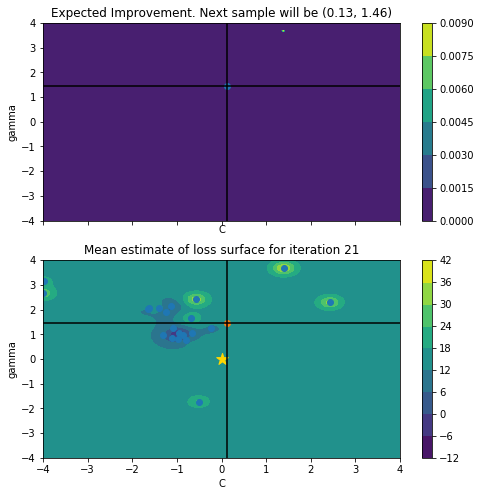

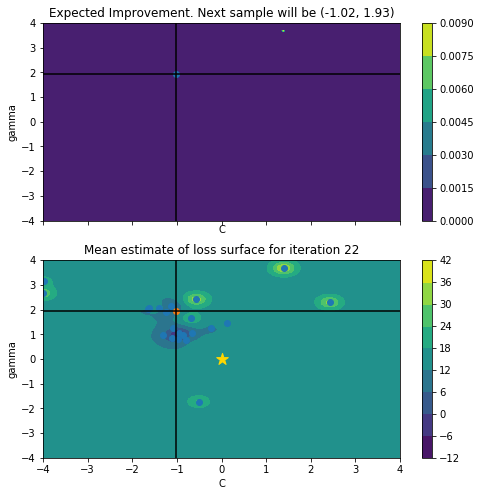

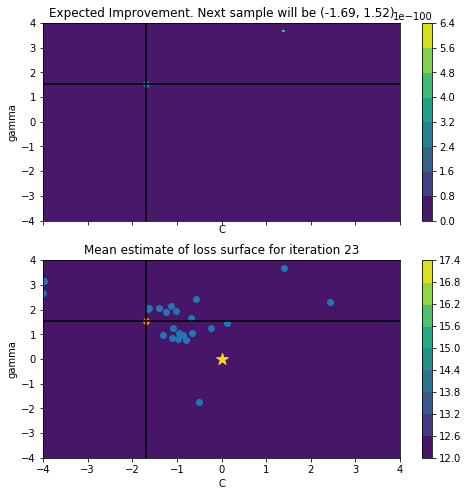

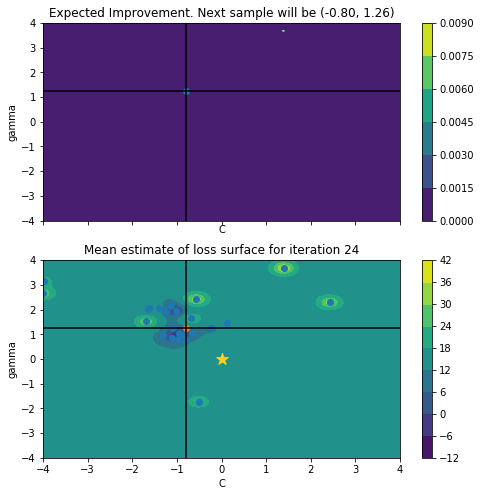

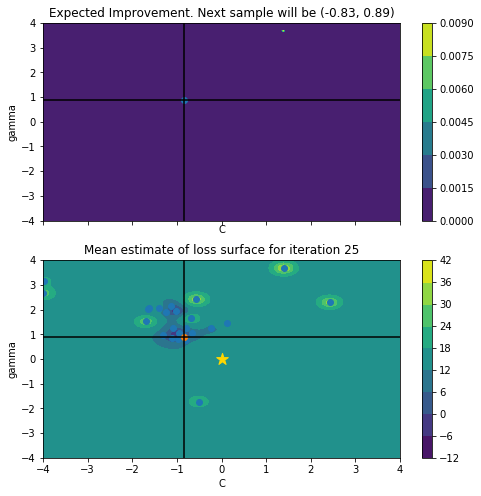

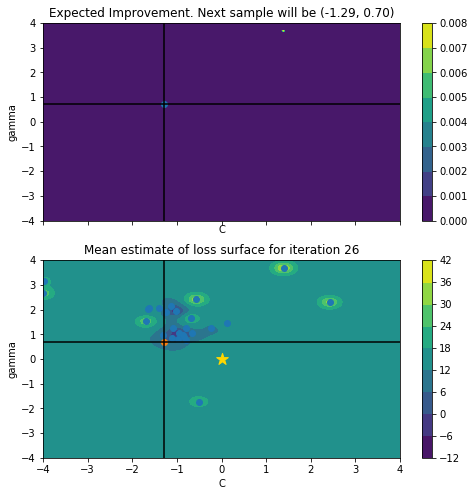

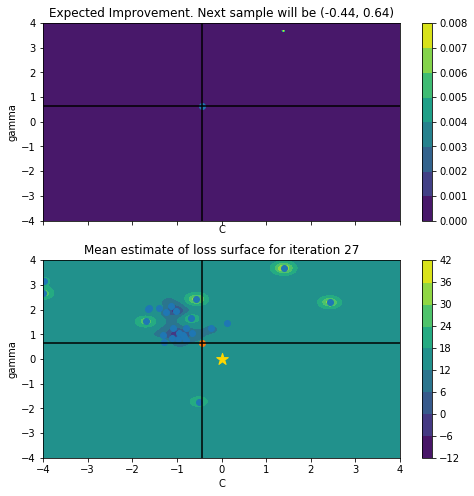

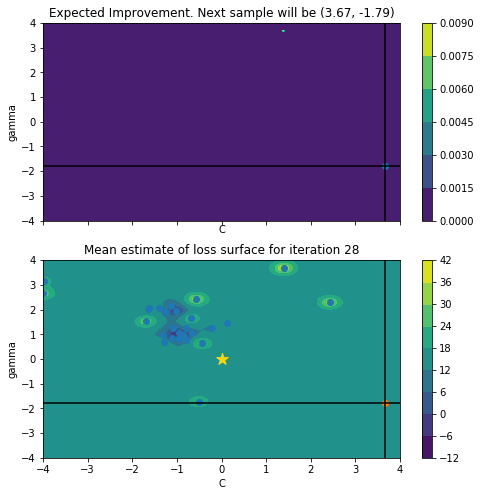

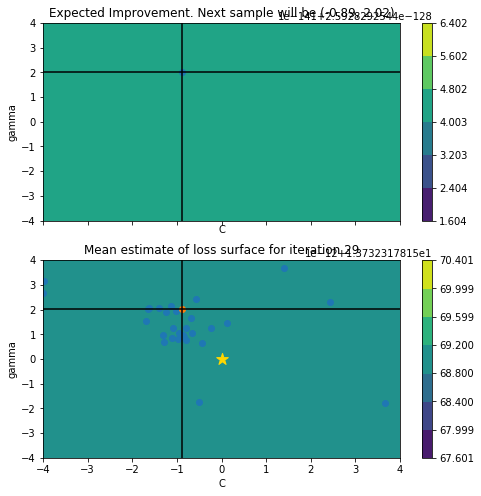

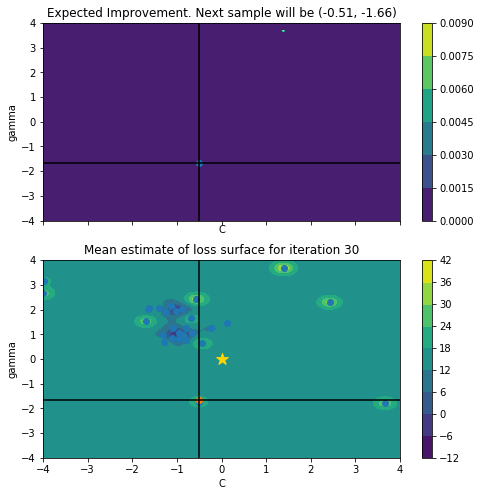

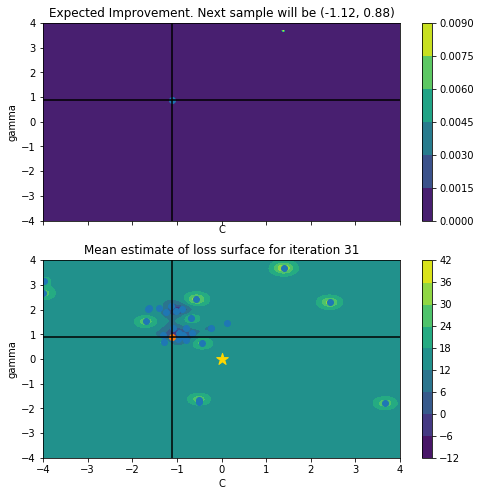

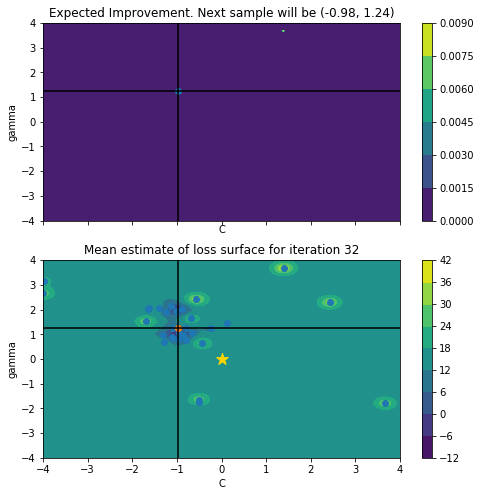

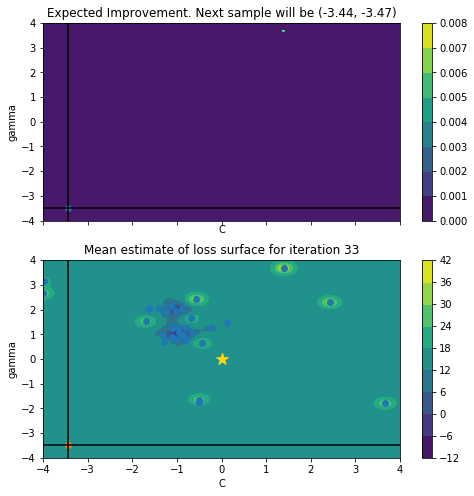

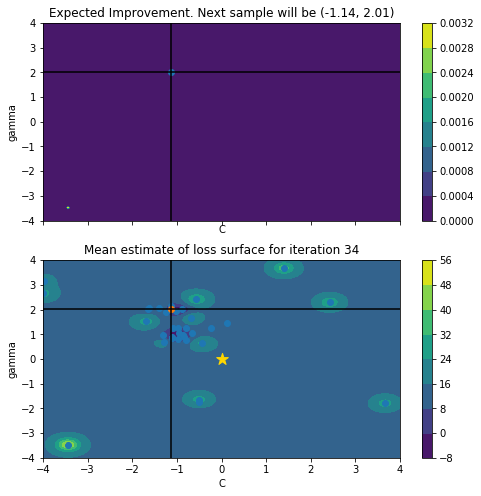

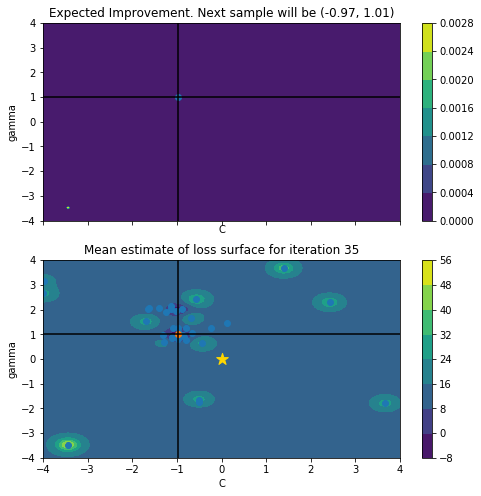

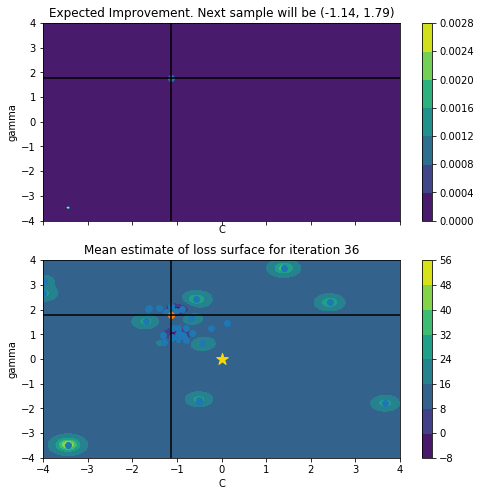

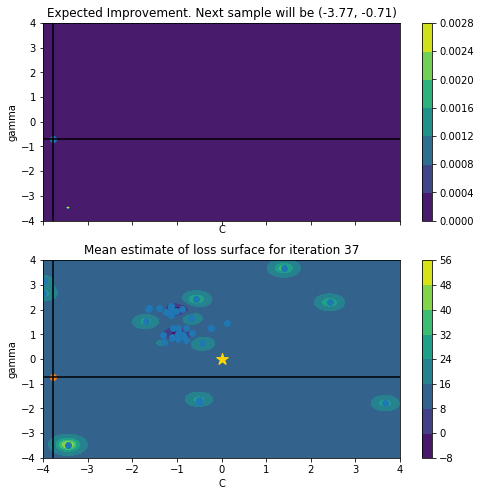

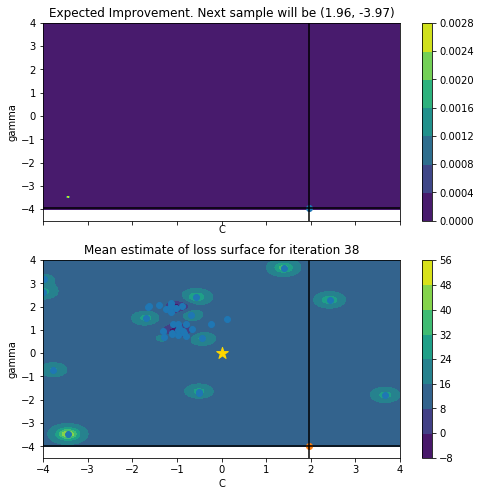

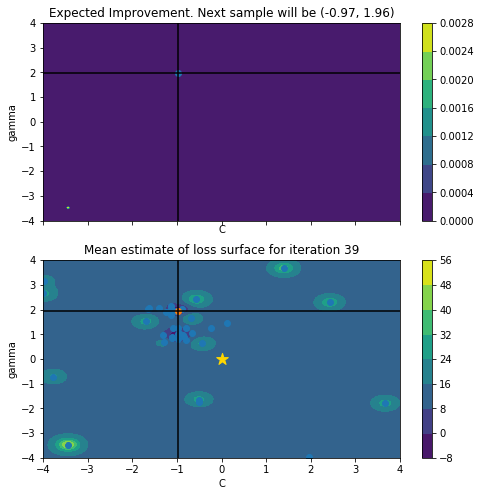

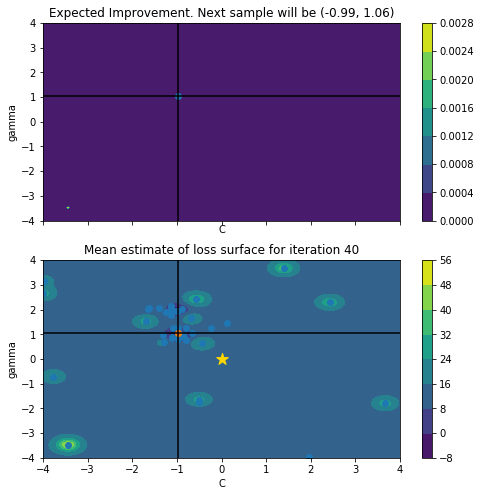

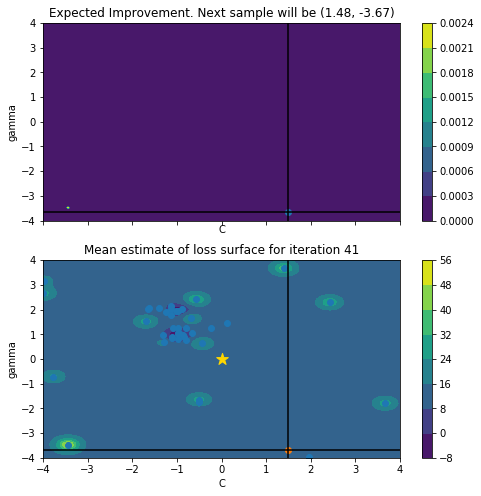

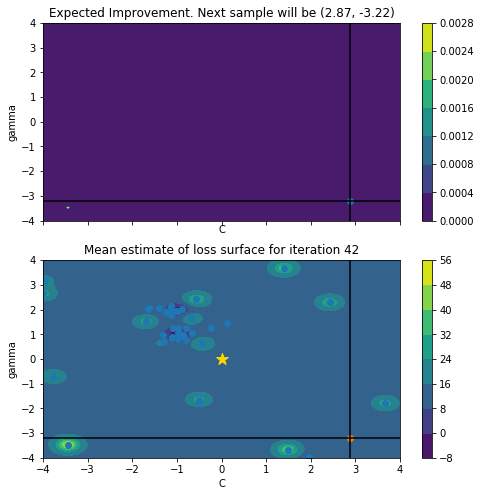

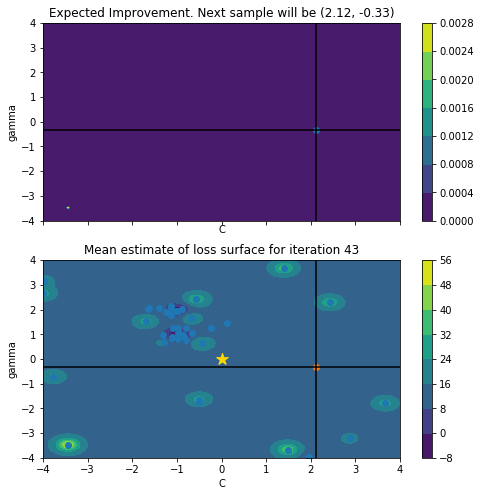

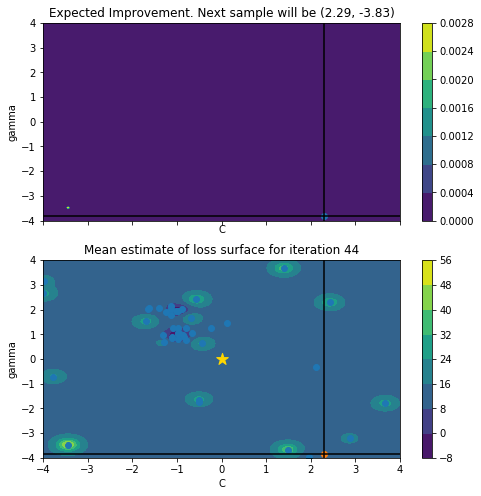

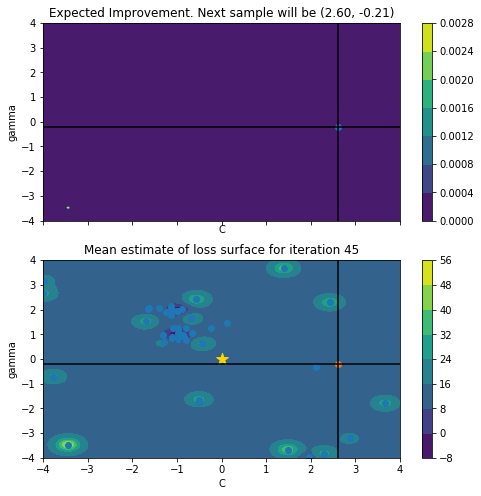

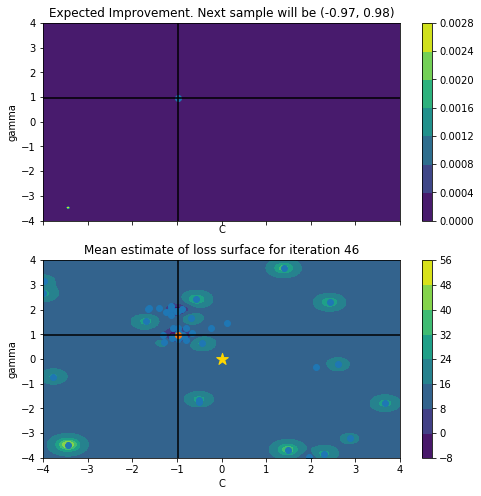

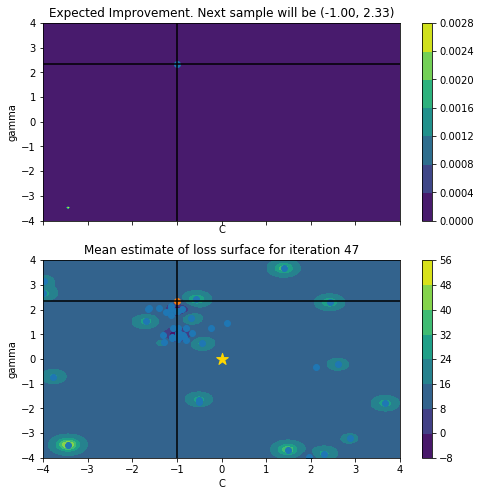

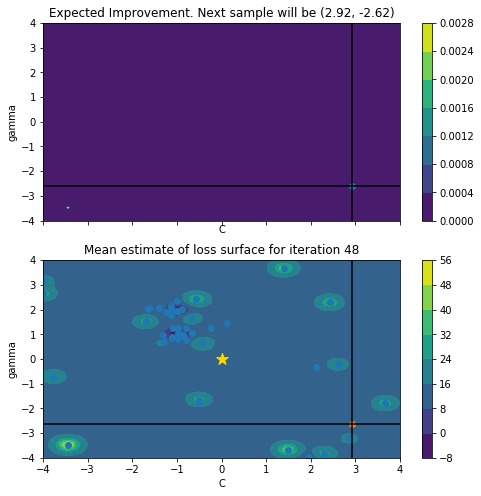

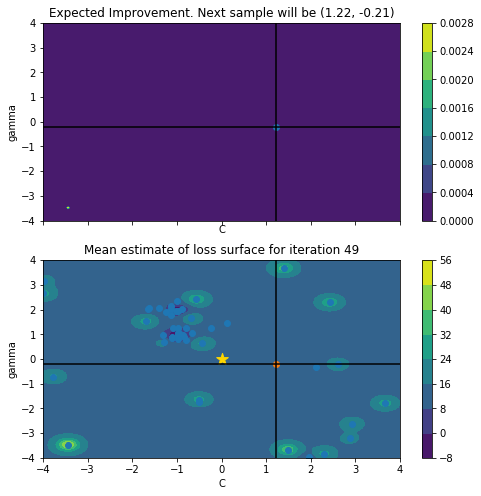

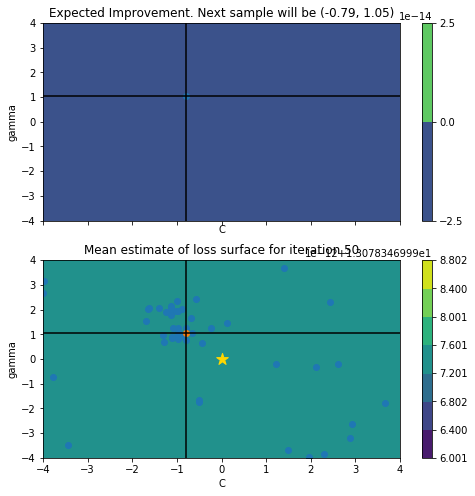

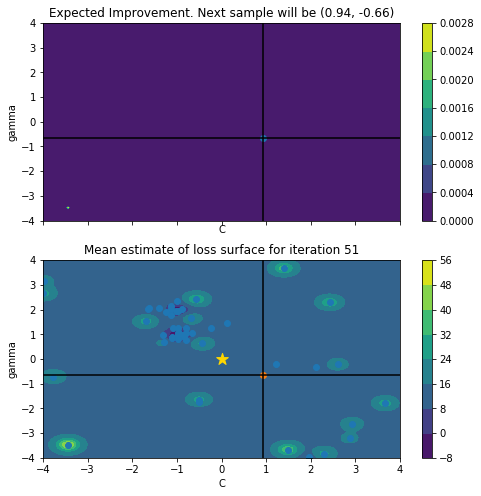

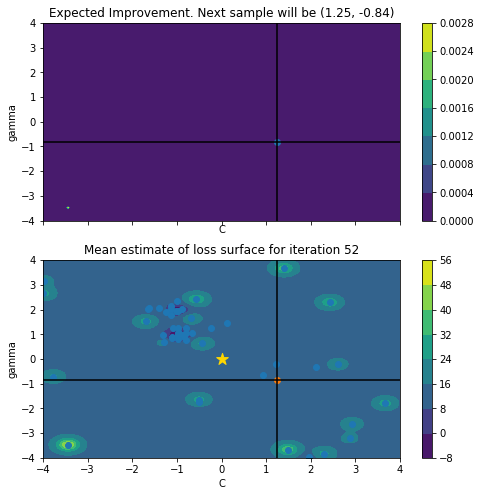

In [43]:
#rc('text', usetex=False)
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0, 0])